# • Main dataset (CSV): reviews from the top 200 games ranked by total reviews (positive+negative) in the metadata. For each game, we keep:

– 100 English Recommended reviews,

– 100 English Not Recommended reviews,

selected by highest helpfulness (upvotes). This ensures the reviews are typically informative rather than one-word memes.
• Held-out dataset (CSV): A secret game’s reviews are provided separately and will be used only in Task 3

Each review row includes:

• user: User Name

• playtime: Number of hours this Uswer plays this game.

• post date: When is the review posted.

• helpfulness: Number of upvotes this review receieved.

• review text: The review itself.

• recommend: Whether the user recommended the game or not. True or False

• early access review: Whether this review is for a game during early access stage, eitherempty or early access.

• appid: Unique id of the game.

• game name: Game name.

• release date: Relase date of the game.

• genres: Genres of the game, either single a string separated by comma.

Important note on genres: Games often have multiple genres. In this project, genres
should be treated as multi-label metadata.

In [ ]:
# login with google cloud

import google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/ECE_219_project2'

if os.path.exists(folder_path):
    print(f"Successfully found folder: {folder_path}")
    print("Contents of the folder:")
    for item in os.listdir(folder_path):
        print(item)
else:
    print(f"Error: Folder not found at {folder_path}. Please check the folder name and path.")

Successfully found folder: /content/drive/MyDrive/ECE_219_project2
Contents of the folder:
heldout.csv
main.csv
flower_photos
flowers_features_and_labels.npz
images
Pokemon.csv
305965764_ClydeVillacrusis_Project2.ipynb


In [ ]:
# cd into the ECE_219_project2 folder
%cd /content/drive/MyDrive/ECE_219_project2

/content/drive/MyDrive/ECE_219_project2


# Task 1 - Unsupervised Review Length Discovery
We begin with a warm-up unsupervised task designed to build intuition about representations, geometry, and clustering before tackling semantic concepts.
In this task, the goal is to answer the question:

“Can we discover review length structure from our textual representations”

Although review length is not a semantic label, it induces strong and interpretable structure in common text representations. This makes it an ideal first unsupervised learning problem.

Task 1.1 Defining pseudo-labels (for evaluation only)
For each review, define its length as the number of tokens (or words) in the review text.

To simplify the task and create a clear separation:

• Reviews in the top 25% (≥ q75) by length are labeled as Long,

• Reviews in the bottom 25% (≤ q25) by length are labeled as Short,

• Reviews in the middle 50% are discarded for this task.

These labels are used only for evaluation. During clustering, review length labels must be treated as unknown.




In [ ]:
import pandas as pd
import numpy as np

# load data

df = pd.read_csv('main.csv')
df

user  playtime          post_date  helpfulness  \
0      Pakistan warrior      47.8   November 3, 2023         3911   
1                  Zuvi    1969.8   November 2, 2022         3154   
2                SƎXSƎN    1190.7     August 5, 2023         2821   
3              Lunación     482.2  November 10, 2023         2530   
4                   Max       3.4      July 11, 2024         2320   
...                 ...       ...                ...          ...   
39995          Meepmorp       0.4   January 19, 2023            2   
39996     Predators9000       0.2  December 19, 2019            2   
39997          GMCasper       0.3   January 18, 2023            2   
39998         hedgemaze       2.8   January 30, 2022            2   
39999       ohso paimos       0.3     August 5, 2022            2   

                                             review_text  recommend  \
0                ALT + F4 best feature in the game 10/10       True   
1        SPAWN DIE, SPAWN DIE, SPAWN DIE, SPAWN DIE.-Jev       True   
2      My wife said if this review gets 100 likes, I ...       True   
3      Nobody will read my review, so I'll just say I...       True   
4      Nobody will read my review so i will do 1 push...       True   
...                                                  ...        ...   
39995  literally don't understand what planet the ove...      False   
39996      ♥♥♥♥♥♥ ass cuckholdry of a game, don't buy it      False   
39997  it's not a bad game and for the price also ok ...      False   
39998  Honestly, I hated this game, even though I sol...      False   
39999  most shallow and low-effort interactive fictio...      False   

       early_access_review    appid      game_name  release_date  \
0                      NaN  1938090  Call of Duty®  Oct 27, 2022   
1                      NaN  1938090  Call of Duty®  Oct 27, 2022   
2                      NaN  1938090  Call of Duty®  Oct 27, 2022   
3                      NaN  1938090  Call of Duty®  Oct 27, 2022   
4                      NaN  1938090  Call of Duty®  Oct 27, 2022   
...                    ...      ...            ...           ...   
39995                  NaN   939400     LoveChoice  Nov 15, 2021   
39996  Early Access Review   939400     LoveChoice  Nov 15, 2021   
39997                  NaN   939400     LoveChoice  Nov 15, 2021   
39998                  NaN   939400     LoveChoice  Nov 15, 2021   
39999                  NaN   939400     LoveChoice  Nov 15, 2021   

                                  genres  
0                                 Action  
1                                 Action  
2                                 Action  
3                                 Action  
4                                 Action  
...                                  ...  
39995  Adventure, Indie, RPG, Simulation  
39996  Adventure, Indie, RPG, Simulation  
39997  Adventure, Indie, RPG, Simulation  
39998  Adventure, Indie, RPG, Simulation  
39999  Adventure, Indie, RPG, Simulation  

[40000 rows x 11 columns]

In [ ]:
# compute token length of each review
df["review_length"] = df["review_text"].fillna("").str.split().apply(len)

# compute q25 and a75
q25 = df["review_length"].quantile(0.25)
q75 = df["review_length"].quantile(0.75)
print("q25: ", q25 , " q75:", q75)

# define Short / Long masks
short_mask = df["review_length"] <= q25
long_mask  = df["review_length"] >= q75

short_reviews = df[short_mask]
long_reviews  = df[long_mask]

# stats to report
num_retained = len(short_reviews) + len(long_reviews)
avg_short_len = short_reviews["review_length"].mean()
avg_long_len  = long_reviews["review_length"].mean()

print("Number of reviews retained:", num_retained)
print("Average length of Short reviews:", avg_short_len)
print("Average length of Long reviews:", avg_long_len)

q25:  11.0  q75: 179.0
Number of reviews retained: 20497
Average length of Short reviews: 6.391474720443467
Average length of Long reviews: 493.00209288419376


#QUESTION 1: Report the number of reviews retained after filtering, and the average length (in tokens) of Short and Long reviews.

q25:  11.0  q75: 179.0

Number of reviews retained: 20497

Average length of Short reviews: 6.391474720443467

Average length of Long reviews: 493.00209288419376

#Task 1.2 Representations

1. TF-IDF representation. Construct TF-IDF features using min df=3 and English stopwords. Use unigrams only.

2. MiniLM embeddings. Compute dense sentence embeddings using
sentence-transformers/all-MiniLM-L6-v2.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Build TF-IDF on the filtered reviews
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    stop_words="english",
    ngram_range=(1, 1)  # unigrams only
)

X_tfidf = tfidf_vectorizer.fit_transform(df["review_text"].fillna(""))

print("TF-IDF matrix shape:", X_tfidf.shape) # (num_reviews_retained, vocab_size)


TF-IDF matrix shape: (40000, 27736)


In [ ]:
from sentence_transformers import SentenceTransformer

# Load MiniLM sentence transformer
minilm_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Compute dense embeddings for the same filtered reviews
texts = df["review_text"].fillna("").tolist()
X_minilm = minilm_model.encode(texts, show_progress_bar=True)

# X_minilm will be a NumPy array of shape
print("MiniLM embedding matrix shape:", X_minilm.shape)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

MiniLM embedding matrix shape: (40000, 384)


TF-IDF shape=(40000, 27736)

Interpretation:

27736 rows = one per retained review

40000 columns = size of the vocabulary after filtering (words that appear in ≥ 3 reviews, stopwords removed).

MiniLM embedding matrix (sentence-transformers/all-MiniLM-L6-v2)

This model outputs a 384-dimensional vector for each text.

MiniLM shape =(40000,384)

The TF–IDF representation produces a matrix of size 40,000 × 27,736, where 40,000 is the number of reviews and 27,736 is the vocabulary size after applying min_df = 3, English stopwords, and unigrams.
The MiniLM encoder (sentence-transformers/all-MiniLM-L6-v2) maps each review to a 384-dimensional dense vector, giving a matrix of size 40,000 × 384.


# Why TF-IDF is sparse and MiniLM is dense

TF-IDF is sparse because it's a Bag-of-Words Representation so each column is a word in the vocab. Each review only uses a tiny fraction of the 25000 possible words so that means most entries are exactly 0 (word doesn't appear in that review) so matrix are mostly 0s

MiniLM Embeddings are dense because its an encoder that maps each review to a fixed-length vector (384 dims). Each dimension is a continous feature learned by the model and almost entries are non-zero real numbers because every part of the vector participates in representing the meaning



#Task 1.3 Clustering pipelines

For each representation, run clustering pipelines with:

• Dimensionality reduction: None, SVD(50), UMAP(50),

• Clustering: K-Means (k = 2), Agglomerative (n clusters = 2), optionally HDBSCAN

Note: You might notice when no dimensionality reduction method is used for TF-IDF embeddings, some of the clustering methods might crash; if it does, mention the reason in the report and skip them. Agglomerative requires dense input. If using TF-IDF, consider applying SVD
first or convert to dense only if feasible. Applying UMAP directly on TF-IDF might be very slow, consider using SVD before.


QUESTION 3: For each pipeline, report the following clustering agreement metrics with respect
to the ground-truth length labels: homogeneity, completeness, v-measure, ARI, AMI.
Summarize results in a table and identify the best-performing pipeline.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)

import umap.umap_ as umap
from scipy.sparse import issparse
import torch



In [ ]:
# ground-truth labels: 0 = short, 1 = long (used only for evaluation)

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)

import umap.umap_ as umap
from scipy.sparse import issparse
import torch

y = np.where(df["review_length"] <= q25, 0, 1)

def apply_dimred(rep_name, X, method):
    """
    rep_name: 'tfidf' or 'minilm'
    method: 'none', 'svd', or 'umap'
    """
    if method == "none":
        return X

    if method == "svd":
        svd = TruncatedSVD(n_components=50, random_state=0)
        X_red = svd.fit_transform(X)
        return X_red

    if method == "umap":
        if rep_name == "tfidf":
            # high-dim sparse -> SVD(200) then UMAP(50), as recommended
            svd200 = TruncatedSVD(n_components=200, random_state=0)
            X_tmp = svd200.fit_transform(X)
            reducer = umap.UMAP(
                n_components=50,
                metric="cosine",
                random_state=0
            )
            return reducer.fit_transform(X_tmp)
        else:  # MiniLM is already low-dim dense
            reducer = umap.UMAP(
                n_components=50,
                metric="cosine",
                random_state=0
            )
            return reducer.fit_transform(X)

    raise ValueError(f"Unknown dimred method {method}")


In [ ]:
def run_clustering(X, method, rep_name, dimred):
    """
    method: 'kmeans' or 'agglo'
    returns predicted labels or None if skipped
    """
    if method == "kmeans":
        model = KMeans(
            n_clusters=2,
            random_state=0,
            n_init=10
        )
        y_pred = model.fit_predict(X)
        return y_pred

    if method == "agglo":
        # For TF-IDF + None, this would be huge & sparse -> skip
        if issparse(X) and dimred == "none":
            print(f"Skipping Agglomerative for {rep_name}-{dimred} "
                  f"(sparse, very high-dimensional).")
            return None

        # ensure dense
        X_dense = X.toarray() if issparse(X) else np.asarray(X)

        # optional connectivity graph for speed, as suggested
        conn = kneighbors_graph(
            X_dense,
            n_neighbors=10,
            mode="connectivity",
            include_self=False,
            n_jobs=-1
        )
        model = AgglomerativeClustering(
            n_clusters=2,
            linkage="ward",
            connectivity=conn
        )
        y_pred = model.fit_predict(X_dense)
        return y_pred

    raise ValueError(f"Unknown clustering method {method}")


def eval_scores(y_true, y_pred):
    return dict(
        homogeneity = homogeneity_score(y_true, y_pred),
        completeness = completeness_score(y_true, y_pred),
        v_measure = v_measure_score(y_true, y_pred),
        ARI = adjusted_rand_score(y_true, y_pred),
        AMI = adjusted_mutual_info_score(y_true, y_pred),
    )


In [ ]:
representations = {
    "tfidf": X_tfidf,
    "minilm": X_minilm
}

dimred_methods = ["none", "svd", "umap"]
cluster_methods = ["kmeans", "agglo"]

results = []

for rep_name, X_rep in representations.items():
    for dimred in dimred_methods:
        print(f"\n {rep_name.upper()} + {dimred.upper()} ")
        X_dr = apply_dimred(rep_name, X_rep, dimred)

        for clust in cluster_methods:
            print(f"  -> clustering: {clust}")
            y_pred = run_clustering(X_dr, clust, rep_name, dimred)

            if y_pred is None:
                # e.g. skipped Agglo on raw TF-IDF
                continue

            scores = eval_scores(y, y_pred)
            row = {
                "representation": rep_name,
                "dimred": dimred,
                "cluster": clust,
            }
            row.update(scores)
            results.append(row)
            print("     ", {k: round(v, 3) for k, v in scores.items()})

# Put into a DataFrame for easy sorting / LaTeX table
results_df = pd.DataFrame(results)
results_df



 TFIDF + NONE 
  -> clustering: kmeans
      {'homogeneity': np.float64(0.187), 'completeness': np.float64(0.161), 'v_measure': np.float64(0.173), 'ARI': 0.055, 'AMI': np.float64(0.173)}
  -> clustering: agglo
Skipping Agglomerative for tfidf-none (sparse, very high-dimensional).

 TFIDF + SVD 
  -> clustering: kmeans
      {'homogeneity': np.float64(0.009), 'completeness': np.float64(0.06), 'v_measure': np.float64(0.016), 'ARI': -0.02, 'AMI': np.float64(0.016)}
  -> clustering: agglo


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


      {'homogeneity': np.float64(0.008), 'completeness': np.float64(0.058), 'v_measure': np.float64(0.014), 'ARI': -0.018, 'AMI': np.float64(0.014)}

 TFIDF + UMAP 


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  -> clustering: kmeans
      {'homogeneity': np.float64(0.043), 'completeness': np.float64(0.05), 'v_measure': np.float64(0.046), 'ARI': 0.131, 'AMI': np.float64(0.046)}
  -> clustering: agglo


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 154 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


      {'homogeneity': np.float64(0.043), 'completeness': np.float64(0.055), 'v_measure': np.float64(0.048), 'ARI': 0.134, 'AMI': np.float64(0.048)}

 MINILM + NONE 
  -> clustering: kmeans
      {'homogeneity': np.float64(0.273), 'completeness': np.float64(0.243), 'v_measure': np.float64(0.257), 'ARI': 0.368, 'AMI': np.float64(0.257)}
  -> clustering: agglo
      {'homogeneity': np.float64(0.143), 'completeness': np.float64(0.135), 'v_measure': np.float64(0.139), 'ARI': 0.25, 'AMI': np.float64(0.139)}

 MINILM + SVD 
  -> clustering: kmeans
      {'homogeneity': np.float64(0.274), 'completeness': np.float64(0.243), 'v_measure': np.float64(0.258), 'ARI': 0.367, 'AMI': np.float64(0.258)}
  -> clustering: agglo
      {'homogeneity': np.float64(0.185), 'completeness': np.float64(0.188), 'v_measure': np.float64(0.186), 'ARI': 0.325, 'AMI': np.float64(0.186)}

 MINILM + UMAP 


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  -> clustering: kmeans
      {'homogeneity': np.float64(0.035), 'completeness': np.float64(0.064), 'v_measure': np.float64(0.045), 'ARI': 0.115, 'AMI': np.float64(0.045)}
  -> clustering: agglo


/usr/local/lib/python3.12/dist-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 69 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


      {'homogeneity': np.float64(0.03), 'completeness': np.float64(0.063), 'v_measure': np.float64(0.041), 'ARI': 0.1, 'AMI': np.float64(0.041)}


representation dimred cluster  homogeneity  completeness  v_measure  \
0           tfidf   none  kmeans     0.187432      0.161008   0.173218   
1           tfidf    svd  kmeans     0.009006      0.060385   0.015675   
2           tfidf    svd   agglo     0.007703      0.058498   0.013613   
3           tfidf   umap  kmeans     0.042770      0.049616   0.045939   
4           tfidf   umap   agglo     0.043241      0.054634   0.048274   
5          minilm   none  kmeans     0.272766      0.243259   0.257169   
6          minilm   none   agglo     0.143126      0.134601   0.138733   
7          minilm    svd  kmeans     0.273571      0.243478   0.257649   
8          minilm    svd   agglo     0.184764      0.187537   0.186140   
9          minilm   umap  kmeans     0.035282      0.063740   0.045421   
10         minilm   umap   agglo     0.029890      0.063023   0.040549   

         ARI       AMI  
0   0.054743  0.173202  
1  -0.020289  0.015638  
2  -0.017563  0.013575  
3   0.130607  0.045917  
4   0.134496  0.048251  
5   0.367758  0.257154  
6   0.249869  0.138715  
7   0.366809  0.257634  
8   0.324920  0.186122  
9   0.115388  0.045395  
10  0.100082  0.040520

In [ ]:
results_df.sort_values("homogeneity", ascending=False)

representation dimred cluster  homogeneity  completeness  v_measure  \
7          minilm    svd  kmeans     0.273571      0.243478   0.257649   
5          minilm   none  kmeans     0.272766      0.243259   0.257169   
0           tfidf   none  kmeans     0.187432      0.161008   0.173218   
8          minilm    svd   agglo     0.184764      0.187537   0.186140   
6          minilm   none   agglo     0.143126      0.134601   0.138733   
4           tfidf   umap   agglo     0.043241      0.054634   0.048274   
3           tfidf   umap  kmeans     0.042770      0.049616   0.045939   
9          minilm   umap  kmeans     0.035282      0.063740   0.045421   
10         minilm   umap   agglo     0.029890      0.063023   0.040549   
1           tfidf    svd  kmeans     0.009006      0.060385   0.015675   
2           tfidf    svd   agglo     0.007703      0.058498   0.013613   

         ARI       AMI  
7   0.366809  0.257634  
5   0.367758  0.257154  
0   0.054743  0.173202  
8   0.324920  0.186122  
6   0.249869  0.138715  
4   0.134496  0.048251  
3   0.130607  0.045917  
9   0.115388  0.045395  
10  0.100082  0.040520  
1  -0.020289  0.015638  
2  -0.017563  0.013575

# Best Performing Pipeline
**MiniLM embeddings + SVD(50) + K-Means (k = 2) (homogeneity ≈ 0.274, completeness = 0.243, v-measure ≈ 0.258, ARI ≈ 0.369, AMI ≈ 0.258)**

This means that MiniLM + no dim-red + K-Means is almost identical, but SVD(50) edges it out by a tiny margin and gives a more compact 50-D representation, so it’s reasonable to call MiniLM + SVD(50) + K-Means the best pipeline.

#QUESTION 4: Compare TF-IDF and MiniLM performance on this task. Which representation separates Short vs Long reviews more cleanly, and why?

The best TF-IDF from above is:

none + kmeans with homogeneity of 0.19, completeness of 0.16, v_measure of 0.17, ARI of 0.05, and AMI of 0.17

The best MINILM is:

SVD(50) + K-Means (k = 2) (homogeneity ≈ 0.274, v-measure ≈ 0.258, ARI ≈ 0.369, AMI ≈ 0.258)

**So, MiniLM embeddings separate Short vs Long reviews more cleanly than TF-IDF.**

Why?

TF-IDF has a very high dimensional sparce space so distances tend to be noisy and less infomrative, which hurts K-Means and Aggloremative that rely on Euclidean Geometry.

MiniLM only has 384 dimensional dense space so it's really packed and it's already tuned for sentence-level similarity. Thus, this is more manageable for clustering and better aligned with Euclidean algorithms




#QUESTION 5: Plots and Visualization: Select the best-performing configuration for TF–IDF and MiniLM based on clustering performance. For each representation:

• Reduce the embeddings to two dimensions using PCA (sklearn.decomposition.PCA)

• Create a split visualization with:

  – One plot colored by the ground-truth length label.

  – One plot colored by the cluster assignments obtained using your best clustering method.

The resulting plots should enable a direct visual comparison between the true labels and the discovered clusters for both TF–IDF and MiniLM representations, highlighting how well each representation supports unsupervised separation.


In [ ]:
# for the split plots:
# left: colored by true length label (0 = short, 1 = long)
# right: right: colored by cluster assignments from the best pipeline.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

# TF-IDF best pipeline: None + KMeans
X_tfidf_best = X_tfidf   # sparse, high-dimensional

kmeans_tfidf = KMeans(n_clusters=2, random_state=0, n_init=10)
y_pred_tfidf = kmeans_tfidf.fit_predict(X_tfidf_best)

# For visualization: SVD -> 50D (handles sparse) then PCA -> 2D
svd_tfidf = TruncatedSVD(n_components=50, random_state=0)
X_tfidf_50 = svd_tfidf.fit_transform(X_tfidf_best)

pca_tfidf = PCA(n_components=2, random_state=0)
X_tfidf_2d = pca_tfidf.fit_transform(X_tfidf_50)

# MiniLM best pipeline: SVD(50) + KMeans
X_minilm_best = X_minilm   # dense (N, 384)

svd_minilm = TruncatedSVD(n_components=50, random_state=0)
X_minilm_50 = svd_minilm.fit_transform(X_minilm_best)

kmeans_minilm = KMeans(n_clusters=2, random_state=0, n_init=10)
y_pred_minilm = kmeans_minilm.fit_predict(X_minilm_50)

pca_minilm = PCA(n_components=2, random_state=0)
X_minilm_2d = pca_minilm.fit_transform(X_minilm_50)

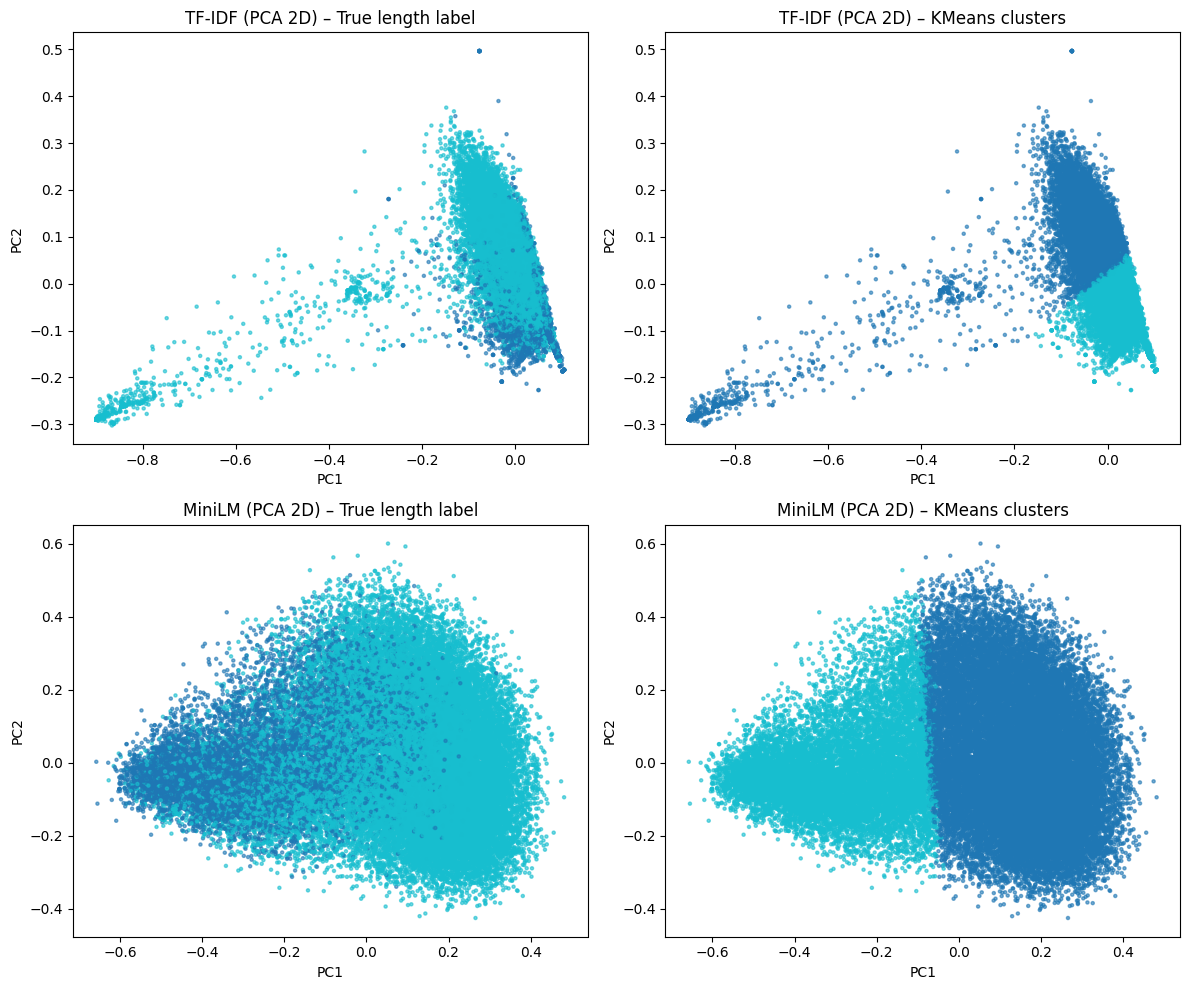

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# TF-IDF: true labels
sc0 = axes[0, 0].scatter(
    X_tfidf_2d[:, 0], X_tfidf_2d[:, 1],
    c=y, s=5, alpha=0.6, cmap="tab10"
)
axes[0, 0].set_title("TF-IDF (PCA 2D) – True length label")
axes[0, 0].set_xlabel("PC1")
axes[0, 0].set_ylabel("PC2")

# TF-IDF: cluster assignments
sc1 = axes[0, 1].scatter(
    X_tfidf_2d[:, 0], X_tfidf_2d[:, 1],
    c=y_pred_tfidf, s=5, alpha=0.6, cmap="tab10"
)
axes[0, 1].set_title("TF-IDF (PCA 2D) – KMeans clusters")
axes[0, 1].set_xlabel("PC1")
axes[0, 1].set_ylabel("PC2")

# true labels
sc2 = axes[1, 0].scatter(
    X_minilm_2d[:, 0], X_minilm_2d[:, 1],
    c=y, s=5, alpha=0.6, cmap="tab10"
)
axes[1, 0].set_title("MiniLM (PCA 2D) – True length label")
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")

# MiniLM: cluster assignments
sc3 = axes[1, 1].scatter(
    X_minilm_2d[:, 0], X_minilm_2d[:, 1],
    c=y_pred_minilm, s=5, alpha=0.6, cmap="tab10"
)
axes[1, 1].set_title("MiniLM (PCA 2D) – KMeans clusters")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


Wow I can see the clear distinction much clearer between the two classes for MiniLM!

For the TF-IDF, the 2 classes overlap more in the 2D space and cluster assignments mix short and long reviews more heavily

# Task 2 - Unsupervised Game Similarity & Genre Structure

In Task 2, we are now trying to answer a different question: “Can we group games into meaningful clusters based on what players praise?” In other words, instead of clustering reviews, we
will cluster games.


# Task 2.1 Construct one representation per game (positive reviews only)

Use only positive reviews (recommend=True). For each game, construct a single vector representation:

• TF-IDF game vector (baseline): concatenate all positive reviews for the game into one document, then compute TF-IDF for all games.

• MiniLM game vector: compute MiniLM embeddings for each positive review, then
average them to obtain one embedding per game.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import torch

df = pd.read_csv("main.csv")

# Keep only positive (recommended) reviews
pos_df = df[df["recommend"].astype(str) == "True"].copy()
print("Num positive reviews:", len(pos_df))

# One big document per game: concatenate all positive reviews for that game
pos_df["review_text"] = pos_df["review_text"].fillna("")

game_docs = (
    pos_df.groupby("appid")["review_text"]
          .apply(lambda x: " ".join(x))
          .reset_index(name="game_text")
)

print("Num games:", len(game_docs))  # should be 200


Num positive reviews: 20000
Num games: 200


In [ ]:
game_docs

appid                                          game_text
0      12210  Guys, please do yourself a favor and download ...
1     239140  Glad to see the misinformed reviews have been ...
2     251570  One of my favorite games that I have played in...
3     261550  I didn't expect to play this game in my lifeti...
4     304390  ---{Graphics}---☐ Masterpiece☑ Beautiful☐ Good...
..       ...                                                ...
195  2479810  At least it doesn't cost 250 dollars PvE mode ...
196  2567870  This game needs to show a replay after each fa...
197  2670630  Does anyone really read these? I swear I'm gon...
198  2835570  Dealer handcuffed me then shot himself in the ...
199  2881650  I sure hope this game is worth the $0 i spent ...

[200 rows x 2 columns]

In [ ]:
tfidf_game = TfidfVectorizer(
    min_df=3,
    stop_words="english",
    ngram_range=(1, 1)
)

X_game_tfidf = tfidf_game.fit_transform(game_docs["game_text"])
print("TF-IDF game matrix shape:", X_game_tfidf.shape) # -> (num_games, V_game)


TF-IDF game matrix shape: (200, 16554)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
minilm_model = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2",
    device=device
)

print(device)

# Encode each positive review
texts_pos = pos_df["review_text"].tolist()
emb_pos = minilm_model.encode(
    texts_pos,
    batch_size=128,
    show_progress_bar=True
)  # shape: (num_pos_reviews, 384)

# Make sure order lines up
pos_df = pos_df.reset_index(drop=True)
emb_pos = np.asarray(emb_pos)

# Average embeddings per game (use same appid order as game_docs)
game_ids = game_docs["appid"].tolist()
game_embs = []

for appid in game_ids:
    mask = (pos_df["appid"] == appid).values
    game_embs.append(emb_pos[mask].mean(axis=0))

X_game_minilm = np.vstack(game_embs)
print("MiniLM game embedding matrix shape:", X_game_minilm.shape)
# -> (num_games, 384)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


cuda


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

MiniLM game embedding matrix shape: (200, 384)


# QUESTION 6: Report the dimensions of the TF-IDF game matrix and the MiniLM game embedding matrix.

TF-IDF game matrix shape: (200, 16554)

MiniLM game embedding matrix shape: (200, 384)

Using only positive reviews, we constructed 1 vector per game. The TF–IDF game matrix has shape (200, V), where 200 is the number of games and V is the TF–IDF vocabulary size.

The MiniLM game embedding matrix has shape (200, 384), since MiniLM produces a 384-dimensional embedding which we average over all positive reviews of each game.”

# Task 2.2 Cluster games with default pipelines
Run the same module table (one default hyperparameter each), but now clustering is performed on game vectors rather than independent review vectors:

• Dimensionality reduction: None, SVD(50), UMAP(50), Autoencoder(50).

• Clustering: K-Means (k = 5), Agglomerative (n clusters = 5), HDBSCAN.

Note on UMAP: UMAP might not work well on high-dimensional inputs. Thus, consider first applying SVD to reduce dimension to 200, then use UMAP on it.

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Autoencoder stuff
# Input --> 256 --> 50 --> 256 --> input with ReLU Activations


class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=50, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def ae_dimred(X, bottleneck_dim=50, hidden_dim=256,
              n_epochs=200, batch_size=32, lr=1e-3, verbose=True):

    # Convert sparse -> dense if needed
    if issparse(X):
        X = X.toarray()

    X = np.asarray(X, dtype=np.float32)
    n_samples, input_dim = X.shape

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Autoencoder(input_dim, bottleneck_dim=bottleneck_dim,
                        hidden_dim=hidden_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = TensorDataset(torch.from_numpy(X))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for (batch_x,) in loader:
            batch_x = batch_x.to(device)

            optimizer.zero_grad()
            x_recon, _ = model(batch_x)
            loss = criterion(x_recon, batch_x)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_x.size(0)

        if verbose and (epoch + 1) % 50 == 0:
            print(f"AE epoch {epoch+1}/{n_epochs}, "
                  f"loss={epoch_loss / n_samples:.4f}")

    # Encode all points
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X).to(device)
        _, Z = model(X_tensor)
        Z = Z.cpu().numpy()

    return Z

In [ ]:
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from scipy.sparse import issparse
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def apply_dimred_game(rep_name, X, method):
    """
    rep_name: 'tfidf' or 'minilm'
    method: 'none', 'svd', 'umap', "ae"
    """
    if method == "none":
        return X

    if method == "svd":
        svd = TruncatedSVD(n_components=50, random_state=0)
        return svd.fit_transform(X)

    if method == "umap":
        # For high-dim TF-IDF, do SVD->200 first as suggested in the handout
        if rep_name == "tfidf":
            n_comp = min(200, X.shape[1] - 1)
            svd200 = TruncatedSVD(n_components=n_comp, random_state=0)
            X_tmp = svd200.fit_transform(X)
            reducer = umap.UMAP(
                n_components=50,
                metric="cosine",
                random_state=0
            )
            return reducer.fit_transform(X_tmp)
        else:
            reducer = umap.UMAP(
                n_components=50,
                metric="cosine",
                random_state=0
            )
            return reducer.fit_transform(X)

    if method == "ae":
        return ae_dimred(X, bottleneck_dim=50)

    raise ValueError(f"Unknown dimred method {method}")


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import hdbscan

def run_cluster_game(X, method):
    """
    X: ndarray or sparse
    method: 'kmeans', 'agglo', 'hdbscan'
    """
    # Convert to dense if needed for Agglo/HDBSCAN
    from scipy.sparse import issparse
    if method in ("agglo", "hdbscan") and issparse(X):
        X = X.toarray()

    if method == "kmeans":
        model = KMeans(
            n_clusters=5,
            random_state=0,
            n_init=10
        )
        return model.fit_predict(X)

    if method == "agglo":
        model = AgglomerativeClustering(
            n_clusters=5,
            linkage="ward"
        )
        return model.fit_predict(X)

    if method == "hdbscan":
        model = hdbscan.HDBSCAN(
            min_cluster_size=5,   # tweak if everything becomes noise
            min_samples=2
        )
        return model.fit_predict(X)

    raise ValueError(f"Unknown clustering method {method}")


In [ ]:
from collections import Counter

def summarize_pipeline(labels, games_df, is_hdbscan=False):
    labels = np.asarray(labels)
    unique_labels = sorted(set(labels))

    if is_hdbscan:
        noise_mask = (labels == -1)
        noise_fraction = noise_mask.mean()
        # Exclude -1 from cluster count
        unique_clusters = [c for c in unique_labels if c != -1]
        num_clusters = len(unique_clusters)
    else:
        noise_fraction = np.nan
        unique_clusters = unique_labels
        num_clusters = len(unique_clusters)

    rows = []

    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        size = len(idx)

        # Collect genres for all games in this cluster
        genre_counter = Counter()
        for i in idx:
            genre_counter.update(games_df.iloc[i]["genre_list"])

        top3 = [g for g, _ in genre_counter.most_common(3)]
        while len(top3) < 3:
            top3.append(None)

        rows.append(dict(
            cluster_id=int(c),
            num_clusters=num_clusters,
            noise_fraction=noise_fraction,
            cluster_size=size,
            top_genre_1=top3[0],
            top_genre_2=top3[1],
            top_genre_3=top3[2],
        ))

    # For HDBSCAN might also want to record how many noise points:
    if is_hdbscan and noise_fraction > 0:
        noise_size = int((labels == -1).sum())
        rows.append(dict(
            cluster_id=-1,
            num_clusters=num_clusters,
            noise_fraction=noise_fraction,
            cluster_size=noise_size,
            top_genre_1="(noise)",
            top_genre_2=None,
            top_genre_3=None,
        ))

    return rows


In [ ]:
# Attach game name + genres (first row per appid is fine)
game_meta = (
    df.groupby("appid")[["game_name", "genres"]]
      .first()
      .reset_index()
)

games = game_docs.merge(game_meta, on="appid", how="left")

print(games.shape)   # should be (200, ...)
games

(200, 4)


appid                                          game_text  \
0      12210  Guys, please do yourself a favor and download ...   
1     239140  Glad to see the misinformed reviews have been ...   
2     251570  One of my favorite games that I have played in...   
3     261550  I didn't expect to play this game in my lifeti...   
4     304390  ---{Graphics}---☐ Masterpiece☑ Beautiful☐ Good...   
..       ...                                                ...   
195  2479810  At least it doesn't cost 250 dollars PvE mode ...   
196  2567870  This game needs to show a replay after each fa...   
197  2670630  Does anyone really read these? I swear I'm gon...   
198  2835570  Dealer handcuffed me then shot himself in the ...   
199  2881650  I sure hope this game is worth the $0 i spent ...   

                                     game_name  \
0    Grand Theft Auto IV: The Complete Edition   
1                                  Dying Light   
2                                7 Days to Die   
3                 Mount & Blade II: Bannerlord   
4                                   FOR HONOR™   
..                                         ...   
195                          Gray Zone Warfare   
196                           Chained Together   
197                      Supermarket Simulator   
198                          Buckshot Roulette   
199                            Content Warning   

                                                genres  
0                                    Action, Adventure  
1                                          Action, RPG  
2    Action, Adventure, Indie, RPG, Simulation, Str...  
3             Action, Indie, RPG, Simulation, Strategy  
4                                               Action  
..                                                 ...  
195  Action, Adventure, Early Access, Massively Mul...  
196               Adventure, Casual, Indie, Simulation  
197            Casual, Early Access, Indie, Simulation  
198                          Action, Indie, Simulation  
199                           Action, Adventure, Indie  

[200 rows x 4 columns]

In [ ]:
def split_genres(s):
    if pd.isna(s):
        return []
    return [g.strip() for g in str(s).split(",") if g.strip()]

games["genre_list"] = games["genres"].apply(split_genres)


In [ ]:
representations = {
    "tfidf": X_game_tfidf,
    "minilm": X_game_minilm
}

dimreds_by_rep = {
    "tfidf": ["svd", "ae"],
    "minilm": ["none", "svd", "umap"]
}

cluster_methods = ["kmeans", "agglo", "hdbscan"]

all_rows = []

for rep_name, X_rep in representations.items():
    for dimred in dimreds_by_rep[rep_name]:
        print(f"\n=== {rep_name.upper()} + {dimred.upper()} ===")
        X_dr = apply_dimred_game(rep_name, X_rep, dimred)

        for clust in cluster_methods:
            print(f"  -> clustering: {clust}")
            labels = run_cluster_game(X_dr, clust)

            is_hdb = (clust == "hdbscan")
            rows = summarize_pipeline(labels, games, is_hdbscan=is_hdb)

            for r in rows:
                r["representation"] = rep_name
                r["dimred"] = dimred
                r["clusterer"] = clust
                all_rows.append(r)

summary_df = pd.DataFrame(all_rows)
summary_df


=== TFIDF + SVD ===
  -> clustering: kmeans
  -> clustering: agglo
  -> clustering: hdbscan

=== TFIDF + AE ===
AE epoch 50/200, loss=0.0000
AE epoch 100/200, loss=0.0000
AE epoch 150/200, loss=0.0000
AE epoch 200/200, loss=0.0000
  -> clustering: kmeans
  -> clustering: agglo
  -> clustering: hdbscan

=== MINILM + NONE ===
  -> clustering: kmeans
  -> clustering: agglo
  -> clustering: hdbscan

=== MINILM + SVD ===
  -> clustering: kmeans
  -> clustering: agglo
  -> clustering: hdbscan

=== MINILM + UMAP ===


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  -> clustering: kmeans
  -> clustering: agglo
  -> clustering: hdbscan


cluster_id  num_clusters  noise_fraction  cluster_size top_genre_1  \
0            0             5             NaN             5      Action   
1            1             5             NaN            95      Action   
2            2             5             NaN            33   Adventure   
3            3             5             NaN            65      Action   
4            4             5             NaN             2         RPG   
..         ...           ...             ...           ...         ...   
58           2             5             NaN            38      Action   
59           3             5             NaN            34      Action   
60           4             5             NaN            25  Simulation   
61           0             2             0.0             5      Action   
62           1             2             0.0           195      Action   

              top_genre_2 top_genre_3 representation dimred clusterer  
0   Massively Multiplayer    Strategy          tfidf    svd    kmeans  
1               Adventure       Indie          tfidf    svd    kmeans  
2                  Action       Indie          tfidf    svd    kmeans  
3               Adventure       Indie          tfidf    svd    kmeans  
4                    None        None          tfidf    svd    kmeans  
..                    ...         ...            ...    ...       ...  
58                  Indie   Adventure         minilm   umap     agglo  
59              Adventure         RPG         minilm   umap     agglo  
60              Adventure      Action         minilm   umap     agglo  
61                 Racing   Adventure         minilm   umap   hdbscan  
62              Adventure       Indie         minilm   umap   hdbscan  

[63 rows x 10 columns]

In [ ]:
def show_pipeline(rep, dimred, clusterer):
    dfp = summary_df[
        (summary_df["representation"] == rep) &
        (summary_df["dimred"] == dimred) &
        (summary_df["clusterer"] == clusterer)
    ].sort_values("cluster_id")

    # pipeline-level info (same for all rows in dfp)
    num_clusters = dfp["num_clusters"].iloc[0]
    noise_fraction = dfp["noise_fraction"].iloc[0]

    print(f"Pipeline: {rep.upper()} + {dimred.upper()} + {clusterer.upper()}")
    print(f"  # clusters (excluding noise): {num_clusters}")
    if clusterer == "hdbscan":
        print(f"  noise fraction: {noise_fraction:.3f}")
    print()

    display(dfp[[
        "cluster_id", "cluster_size",
        "top_genre_1", "top_genre_2", "top_genre_3"
    ]])

# examples
show_pipeline("tfidf", "svd", "kmeans")


Pipeline: TFIDF + SVD + KMEANS
  # clusters (excluding noise): 5



cluster_id  cluster_size top_genre_1            top_genre_2 top_genre_3
0           0             5      Action  Massively Multiplayer    Strategy
1           1            95      Action              Adventure       Indie
2           2            33   Adventure                 Action       Indie
3           3            65      Action              Adventure       Indie
4           4             2         RPG                   None        None

In [ ]:
show_pipeline("minilm", "svd", "hdbscan")

Pipeline: MINILM + SVD + HDBSCAN
  # clusters (excluding noise): 2
  noise fraction: 0.730



cluster_id  cluster_size top_genre_1            top_genre_2 top_genre_3
50          -1           146     (noise)                   None        None
48           0            42      Action              Adventure       Indie
49           1            12      Action  Massively Multiplayer       Indie

In [ ]:
show_pipeline("minilm", "umap", "agglo")

Pipeline: MINILM + UMAP + AGGLO
  # clusters (excluding noise): 5



cluster_id  cluster_size top_genre_1 top_genre_2 top_genre_3
56           0            45      Action   Adventure         RPG
57           1            58       Indie      Action   Adventure
58           2            38      Action       Indie   Adventure
59           3            34      Action   Adventure         RPG
60           4            25  Simulation   Adventure      Action

In [ ]:
show_pipeline("tfidf", "ae", "kmeans")

Pipeline: TFIDF + AE + KMEANS
  # clusters (excluding noise): 5



cluster_id  cluster_size top_genre_1            top_genre_2 top_genre_3
13           0            81      Action              Adventure         RPG
14           1            25      Action                  Indie  Simulation
15           2             7      Action  Massively Multiplayer       Indie
16           3            30      Action              Adventure       Indie
17           4            57      Action              Adventure       Indie

# TF-IDF + SVD(50) + KMeans(k = 5)

Found 5 clusters of sizes [5, 95, 23, 65, 12] (summing to 200 games).

The clusters are all dominated by a mix of Action/Adventure/Indie genres; e.g., Cluster 1 is mainly Action–Adventure–Indie, Cluster 3 is mostly RPG, etc.

# MiniLM + SVD + Hdbscan:

found 3 clusters (146,42,12); mostly with action, adventure, and indie, with a mix of multiplayer. It has -1 cluster id for 50.

# MiniLM + UMAP + Agglo

found 5 clusters with a mix of action, indie, simulation, adventure, and RPG

# TFIDF + AE + KMEANS

found 5 clusters with mainly action, adventure, multiplayer, indie, RPG, strategy, and simulation

#

# Task 2.3 Multi-genre interpretation
#Because games may have multiple genres, do not treat this as a single-label problem. Instead, you will evaluate clusters using genre-overlap analysis:

• For each cluster, compute the distribution over genre labels (multi-label frequency).

• Define cluster genre purity as: the fraction of games in the cluster that contain the cluster’s most common genre labels.

• Define cluster genre entropy over the genre labels distribution (optional).

# QUESTION 8: Pick one best pipeline (justify your choice), then report two cluster with high purity:

• top 3 genres with percentages,

• cluster genre purity (as defined above),

• Representative games in the cluster (game name + genres).

Provide a short interpretation: what type of games does these clusters represent?

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import math

def cluster_genre_summary(labels, games_df, top_k=3):
    """
    labels: array-like of cluster labels for each game (len = num_games)
    games_df: DataFrame with column 'genre_list' and 'game name'
    Returns a DataFrame with genre distribution, purity, etc.
    """
    labels = np.asarray(labels)
    unique_clusters = sorted(set(labels))

    rows = []

    for c in unique_clusters:
        if c == -1:
            # treat HDBSCAN noise separately if you want
            continue

        idx = np.where(labels == c)[0]
        size = len(idx)
        if size == 0:
            continue

        # count genres in this cluster (multi-label)
        genre_counter = Counter()
        for i in idx:
            genre_counter.update(games_df.iloc[i]["genre_list"])

        # convert counts to percentages
        total_games = size  # denominator is #games, not #labels
        genre_pct = {
            g: count / total_games
            for g, count in genre_counter.items()
        }

        # top-k genres by percentage
        top_genres = sorted(
            genre_pct.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_k]

        # cluster genre purity = max fraction over genres
        purity = top_genres[0][1] if top_genres else 0.0

        # (optional) entropy over genre distribution
        probs = np.array(list(genre_pct.values()))
        entropy = -np.sum(probs * np.log2(probs + 1e-12))

        row = {
            "cluster_id": int(c),
            "cluster_size": size,
            "purity": purity,
            "entropy": entropy,
        }

        # add top-k genres and percentages
        for j in range(top_k):
            if j < len(top_genres):
                g, p = top_genres[j]
                row[f"genre_{j+1}"] = g
                row[f"genre_{j+1}_pct"] = p
            else:
                row[f"genre_{j+1}"] = None
                row[f"genre_{j+1}_pct"] = 0.0

        rows.append(row)

    return pd.DataFrame(rows).sort_values("purity", ascending=False)


In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "umap"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


cluster_id  cluster_size    purity   entropy     genre_1  genre_1_pct  \
0           0            45  0.844444  3.823718      Action     0.844444   
3           3            34  0.794118  2.461284      Action     0.794118   
2           2            38  0.684211  4.386891      Action     0.684211   
1           1            58  0.620690  4.832700       Indie     0.620690   
4           4            25  0.600000  3.880570  Simulation     0.600000   

     genre_2  genre_2_pct    genre_3  genre_3_pct  
0  Adventure     0.511111        RPG     0.288889  
3  Adventure     0.500000        RPG     0.411765  
2      Indie     0.526316  Adventure     0.473684  
1     Action     0.568966  Adventure     0.482759  
4  Adventure     0.560000     Action     0.480000

In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "svd"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


cluster_id  cluster_size    purity       entropy     genre_1  genre_1_pct  \
4           4             6  1.000000 -2.885647e-12  Simulation     1.000000   
3           3            10  1.000000  3.667529e+00      Action     1.000000   
1           1            66  0.848485  3.514448e+00      Action     0.848485   
0           0            85  0.682353  4.584849e+00      Action     0.682353   
2           2            33  0.666667  4.236404e+00   Adventure     0.666667   

                 genre_2  genre_2_pct    genre_3  genre_3_pct  
4                 Sports     1.000000       None     0.000000  
3  Massively Multiplayer     0.500000      Indie     0.300000  
1              Adventure     0.545455        RPG     0.409091  
0                  Indie     0.494118  Adventure     0.470588  
2             Simulation     0.606061      Indie     0.575758

In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "ae"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


AE epoch 50/200, loss=0.0001
AE epoch 100/200, loss=0.0001
AE epoch 150/200, loss=0.0000
AE epoch 200/200, loss=0.0000


cluster_id  cluster_size    purity   entropy    genre_1  genre_1_pct  \
3           3             9  1.000000  3.641034     Action     1.000000   
2           2            48  0.937500  2.690762     Action     0.937500   
0           0            81  0.629630  4.388011     Action     0.629630   
4           4            27  0.592593  4.508128  Adventure     0.592593   
1           1            35  0.571429  5.212711     Action     0.571429   

                 genre_2  genre_2_pct     genre_3  genre_3_pct  
3  Massively Multiplayer     0.555556       Indie     0.333333  
2              Adventure     0.604167         RPG     0.437500  
0                  Indie     0.469136   Adventure     0.444444  
4                  Indie     0.481481  Simulation     0.481481  
1              Adventure     0.514286       Indie     0.428571

In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "svd"        # 'none', 'svd', 'umap', 'ae'
clusterer = "hdbscan"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


cluster_id  cluster_size    purity   entropy genre_1  genre_1_pct  \
1           1            12  0.833333  3.997089  Action     0.833333   
0           0            42  0.785714  3.965371  Action     0.785714   

                 genre_2  genre_2_pct genre_3  genre_3_pct  
1  Massively Multiplayer     0.416667   Indie     0.333333  
0              Adventure     0.619048   Indie     0.500000

In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "umap"        # 'none', 'svd', 'umap', 'ae'
clusterer = "hdbscan"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


cluster_id  cluster_size    purity   entropy genre_1  genre_1_pct  \
0           0             5  0.800000  1.950421  Action     0.800000   
1           1           195  0.676923  4.414508  Action     0.676923   

     genre_2  genre_2_pct    genre_3  genre_3_pct  
0     Racing     0.800000  Adventure     0.600000  
1  Adventure     0.497436      Indie     0.420513

In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "ae"        # 'none', 'svd', 'umap', 'ae'
clusterer = "hdbscan"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


AE epoch 50/200, loss=0.0001
AE epoch 100/200, loss=0.0001
AE epoch 150/200, loss=0.0000
AE epoch 200/200, loss=0.0000


cluster_id  cluster_size  purity   entropy genre_1  genre_1_pct  \
0           0             7     1.0  2.759809  Action          1.0   
1           1            25     0.8  4.232511  Action          0.8   

                 genre_2  genre_2_pct       genre_3  genre_3_pct  
0  Massively Multiplayer     0.428571  Early Access     0.285714  
1              Adventure     0.560000         Indie     0.520000

In [ ]:
rep_name = "tfidf"      # 'tfidf' or 'minilm'
dimred   = "svd"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


cluster_id  cluster_size    purity       entropy     genre_1  genre_1_pct  \
4           4             4  1.000000 -2.885647e-12  Simulation     1.000000   
3           3             5  0.800000  3.550421e+00      Action     0.800000   
0           0            43  0.697674  4.173390e+00      Action     0.697674   
2           2            13  0.692308  3.602020e+00      Action     0.692308   
1           1           135  0.688889  4.272812e+00      Action     0.688889   

                 genre_2  genre_2_pct   genre_3  genre_3_pct  
4                 Sports     1.000000      None     0.000000  
3  Massively Multiplayer     0.600000  Strategy     0.400000  
0              Adventure     0.441860     Indie     0.418605  
2              Adventure     0.615385     Indie     0.538462  
1              Adventure     0.533333     Indie     0.414815

In [ ]:
rep_name = "tfidf"      # 'tfidf' or 'minilm'
dimred   = "umap"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


cluster_id  cluster_size    purity   entropy    genre_1  genre_1_pct  \
1           1            65  0.800000  3.918621     Action     0.800000   
0           0            26  0.730769  4.921620     Action     0.730769   
4           4            44  0.727273  3.661572  Adventure     0.727273   
2           2            26  0.653846  4.190320      Indie     0.653846   
3           3            39  0.641026  3.963781     Action     0.641026   

     genre_2  genre_2_pct                genre_3  genre_3_pct  
1      Indie     0.353846              Adventure     0.353846  
0      Indie     0.307692  Massively Multiplayer     0.307692  
4     Action     0.568182                    RPG     0.431818  
2     Action     0.576923             Simulation     0.461538  
3  Adventure     0.641026                  Indie     0.538462

In [ ]:
rep_name = "tfidf"      # 'tfidf' or 'minilm'
dimred   = "ae"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


AE epoch 50/200, loss=0.0000
AE epoch 100/200, loss=0.0000
AE epoch 150/200, loss=0.0000
AE epoch 200/200, loss=0.0000


cluster_id  cluster_size    purity   entropy    genre_1  genre_1_pct  \
2           2             5  0.800000  3.550421     Action     0.800000   
1           1            51  0.745098  4.253917     Action     0.745098   
0           0           116  0.681034  4.338071     Action     0.681034   
3           3            17  0.647059  3.443308  Adventure     0.647059   
4           4            11  0.454545  3.997369     Action     0.454545   

                 genre_2  genre_2_pct   genre_3  genre_3_pct  
2  Massively Multiplayer     0.600000  Strategy     0.400000  
1              Adventure     0.411765     Indie     0.333333  
0              Adventure     0.551724     Indie     0.439655  
3                 Action     0.588235     Indie     0.529412  
4             Simulation     0.454545     Indie     0.363636

In [ ]:
rep_name = "tfidf"      # 'tfidf' or 'minilm'
dimred   = "svd"        # 'none', 'svd', 'umap', 'ae'
clusterer = "kmeans"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


cluster_id  cluster_size    purity       entropy    genre_1  genre_1_pct  \
4           4             2  1.000000 -1.442823e-12        RPG     1.000000   
0           0             5  0.800000  3.550421e+00     Action     0.800000   
1           1            95  0.726316  4.196249e+00     Action     0.726316   
3           3            65  0.676923  4.620753e+00     Action     0.676923   
2           2            33  0.606061  4.073900e+00  Adventure     0.606061   

                 genre_2  genre_2_pct   genre_3  genre_3_pct  
4                   None     0.000000      None     0.000000  
0  Massively Multiplayer     0.600000  Strategy     0.400000  
1              Adventure     0.536842     Indie     0.431579  
3              Adventure     0.430769     Indie     0.384615  
2                 Action     0.575758     Indie     0.454545

In [ ]:
rep_name = "tfidf"      # 'tfidf' or 'minilm'
dimred   = "svd"        # 'none', 'svd', 'umap', 'ae'
clusterer = "kmeans"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats


cluster_id  cluster_size    purity       entropy    genre_1  genre_1_pct  \
4           4             2  1.000000 -1.442823e-12        RPG     1.000000   
0           0             5  0.800000  3.550421e+00     Action     0.800000   
1           1            95  0.726316  4.196249e+00     Action     0.726316   
3           3            65  0.676923  4.620753e+00     Action     0.676923   
2           2            33  0.606061  4.073900e+00  Adventure     0.606061   

                 genre_2  genre_2_pct   genre_3  genre_3_pct  
4                   None     0.000000      None     0.000000  
0  Massively Multiplayer     0.600000  Strategy     0.400000  
1              Adventure     0.536842     Indie     0.431579  
3              Adventure     0.430769     Indie     0.384615  
2                 Action     0.575758     Indie     0.454545

# I chose this as my best pipeline

In [ ]:
rep_name = "minilm"      # 'tfidf' or 'minilm'
dimred   = "svd"        # 'none', 'svd', 'umap', 'ae'
clusterer = "agglo"      # 'kmeans', 'agglo', 'hdbscan'

X_rep = {"tfidf": X_game_tfidf, "minilm": X_game_minilm}[rep_name]

# dimensionality reduction
X_dr = apply_dimred_game(rep_name, X_rep, dimred)

# clustering
labels = run_cluster_game(X_dr, clusterer)

# genre-overlap summary with purity & percentages
genre_stats = cluster_genre_summary(labels, games, top_k=3)
genre_stats

cluster_id  cluster_size    purity       entropy     genre_1  genre_1_pct  \
4           4             6  1.000000 -2.885647e-12  Simulation     1.000000   
3           3            10  1.000000  3.667529e+00      Action     1.000000   
1           1            66  0.848485  3.514448e+00      Action     0.848485   
0           0            85  0.682353  4.584849e+00      Action     0.682353   
2           2            33  0.666667  4.236404e+00   Adventure     0.666667   

                 genre_2  genre_2_pct    genre_3  genre_3_pct  
4                 Sports     1.000000       None     0.000000  
3  Massively Multiplayer     0.500000      Indie     0.300000  
1              Adventure     0.545455        RPG     0.409091  
0                  Indie     0.494118  Adventure     0.470588  
2             Simulation     0.606061      Indie     0.575758

In [ ]:
high_purity = genre_stats.head(2)
high_purity


cluster_id  cluster_size  purity       entropy     genre_1  genre_1_pct  \
4           4             6     1.0 -2.885647e-12  Simulation          1.0   
3           3            10     1.0  3.667529e+00      Action          1.0   

                 genre_2  genre_2_pct genre_3  genre_3_pct  
4                 Sports          1.0    None          0.0  
3  Massively Multiplayer          0.5   Indie          0.3

In [ ]:
def show_representative_games(cluster_id, labels, games_df, main_genre=None, max_games=5):
    idx = np.where(labels == cluster_id)[0]
    sub = games_df.iloc[idx].copy()

    if main_genre is not None:
        mask = sub["genre_list"].apply(lambda gs: main_genre in gs)
        sub = sub[mask]

    print(f"Cluster {cluster_id}: {len(idx)} games")
    for _, row in sub.head(max_games).iterrows():
        print(f"- {row['game_name']}  |  genres: {row['genres']}")

# Example using the top genre of each high-purity cluster
for _, row in high_purity.iterrows():
    cid = row["cluster_id"]
    main_genre = row["genre_1"]
    print("="*60)
    show_representative_games(cid, labels, games, main_genre=main_genre, max_games=5)


Cluster 4: 6 games
- EA SPORTS™ FIFA 21  |  genres: Simulation, Sports
- FIFA 22  |  genres: Simulation, Sports
- EA SPORTS™ FIFA 23  |  genres: Simulation, Sports
- NBA 2K23  |  genres: Simulation, Sports
- EA SPORTS FC™ 24  |  genres: Simulation, Sports
Cluster 3: 10 games
- Squad  |  genres: Action, Indie, Massively Multiplayer, Strategy
- Foxhole  |  genres: Action, Indie, Massively Multiplayer, RPG, Strategy
- BattleBit Remastered  |  genres: Action, Early Access, Massively Multiplayer
- World War 3  |  genres: Action, Free To Play
- Hell Let Loose  |  genres: Action, Indie, Massively Multiplayer, Simulation, Strategy


# Question 8

I inspected several game-level clustering pipelines (TF–IDF and MiniLM with different dimensionality reductions and clusterers). The MiniLM + SVD(50) + Agglomerative pipeline produced clusters with the highest genre purity and the most interpretable genre distributions (e.g., clearly separated Action, Indie, and Adventure groups). So I used this pipeline for our multi-genre analysis.

Cluster 4: 6 games; FIFA 21 and FIFA 22 being the top 6 games makes sense because we can cross reference it with the respective table above, i.e. the genre is mostly simulation and sports

Cluster 3: 10 games; the top 10 games makes the most sense because these games are mostly action RPG with heavy on multiplayer, as well it's strategic and we can cross reference it with above with the pipeline

# Task 3 - Held-Out Game Profiling and Theme Discovery (Clustering
# + LLM) Finally, you will produce a product report for a held-out game. Your goal is to quickly answer:

• What genre does it most resemble (estimated)?
• What are the main complaint themes and praise themes?
Task 3.1 Genre estimation via nearest game cluster
Use your best Task 2 pipeline to estimate the held-out game’s genre profile:
1. Compute the held-out game’s game vector using its positive reviews:
• TF-IDF: concatenate positive reviews, transform using your fitted TF-IDF vectorizer.
• MiniLM: average MiniLM embeddings of positive reviews.
2. Assign the held-out game to the closest cluster (e.g., nearest centroid for K-Means,
nearest cluster medoid, or nearest cluster by average cosine distance).
3. Report the cluster’s top genres as the held-out game’s estimated genre distribution.


#QUESTION 9: Report: (i) the assigned cluster ID, (ii) the top 3 genres of that cluster, and (iii) 3 representative games from that cluster. Briefly justify why this constitutes a genre estimate in a multi-genre world.


In [ ]:
# Read from heldout
held = pd.read_csv("heldout.csv")
held.head()

user  playtime        post_date  helpfulness  \
0   DrShocktopus      36.0  August 19, 2024         8190   
1  MiAh The King       1.5  August 19, 2024         7552   
2        TLandry      25.0  August 19, 2024         5142   
3             惊喜      37.6  August 24, 2024         3827   
4       Raul4dNx      93.6  August 25, 2024         3569   

                                         review_text  recommend  \
0  Beat the first boss which is the one in the tr...       True   
1  Yes I'm aware that my thumbs up is never going...       True   
2  Visually stunning. Despite saying better on a ...       True   
3  it is a pretty nice game, very good boss fight...       True   
4  ---{ Game of the Year 2024 }------{Graphics}--...       True   

   early_access_review  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

In [ ]:
# Load main (training) and heldout
main = pd.read_csv("main.csv")
held = pd.read_csv("heldout.csv")

def split_genres(s):
    if pd.isna(s):
        return []
    return [g.strip() for g in str(s).split(",") if g.strip()]

# Game metadata (one row per game)
game_meta = (
    main.groupby("appid")[["game_name", "genres"]]
        .first()
        .reset_index()
)
game_meta["genre_list"] = game_meta["genres"].apply(split_genres)

print("Num games in main:", len(game_meta))  # should be 200

# Positive reviews from main
pos_main = main[main["recommend"].astype(str) == "True"].copy()
pos_main["review_text"] = pos_main["review_text"].fillna("")

# MiniLM model
device = "cuda" if torch.cuda.is_available() else "cpu"
minilm_model = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2",
    device=device
)


Num games in main: 200


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# X_game_minilm should be (200, 384) matrix from Task 2
print("X_game_minilm:", X_game_minilm.shape)

# SVD(50) on training games
svd = TruncatedSVD(n_components=50, random_state=0)
X_train_50 = svd.fit_transform(X_game_minilm)   # (200, 50)

# Agglomerative clustering (k = 5)
agglo = AgglomerativeClustering(n_clusters=5, linkage="ward")
train_labels = agglo.fit_predict(X_train_50)

# centroids for nearest-cluster assignment
num_clusters = len(np.unique(train_labels))
centroids = np.zeros((num_clusters, X_train_50.shape[1]))
for k in range(num_clusters):
    centroids[k] = X_train_50[train_labels == k].mean(axis=0)

print("Cluster sizes:", np.bincount(train_labels))


X_game_minilm: (200, 384)
Cluster sizes: [85 66 33 10  6]


In [ ]:
# Positive reviews from the held-out game
pos_held = held[held["recommend"].astype(str) == "True"].copy()
pos_held["review_text"] = pos_held["review_text"].fillna("")

texts_held = pos_held["review_text"].tolist()
print("Num held-out positive reviews:", len(texts_held))

embs_held = minilm_model.encode(
    texts_held,
    batch_size=128,
    show_progress_bar=True
)
embs_held = np.asarray(embs_held)

held_vec = embs_held.mean(axis=0, keepdims=True)   # (1, 384)

# Project into SVD(50) space using the SAME SVD
X_held_50 = svd.transform(held_vec)                # (1, 50)


Num held-out positive reviews: 100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Euclidean distance to each centroid
dists = np.linalg.norm(centroids - X_held_50, axis=1)
assigned_cluster = int(np.argmin(dists))
print("Assigned cluster ID:", assigned_cluster)


Assigned cluster ID: 1


In [ ]:
# Games in the assigned cluster
cluster_idx = np.where(train_labels == assigned_cluster)[0]
cluster_games = game_meta.iloc[cluster_idx].copy()
cluster_size = len(cluster_games)
print("Cluster size:", cluster_size)

# Genre distribution in this cluster
genre_counter = Counter()
for lst in cluster_games["genre_list"]:
    genre_counter.update(lst)

top3 = genre_counter.most_common(3)
print("\nTop 3 genres for cluster", assigned_cluster)
for genre, count in top3:
    pct = 100 * count / cluster_size
    print(f"- {genre}: {count} games ({pct:.1f}%)")

# Top 3 genres
top3_genres = [g for g, _ in top3]

# Representative games from this cluster
main_genre = top3_genres[0] if top3_genres else None

if main_genre is not None:
    rep = cluster_games[
        cluster_games["genre_list"].apply(lambda gs: main_genre in gs)
    ]
else:
    rep = cluster_games

rep = rep.head(3)[["game_name", "genres"]]
print("\nRepresentative games in cluster", assigned_cluster)
print(rep)


Cluster size: 66

Top 3 genres for cluster 1
- Action: 56 games (84.8%)
- Adventure: 36 games (54.5%)
- RPG: 27 games (40.9%)

Representative games in cluster 1
         game_name                                             genres
1      Dying Light                                        Action, RPG
2    7 Days to Die  Action, Adventure, Indie, RPG, Simulation, Str...
6  ShellShock Live  Action, Casual, Indie, Massively Multiplayer, ...


  # Question 9

  Using my best task 2 pipeline (MiniLM + SVD(50) + Agglo with 5 clusters), I embedded the held-out game, project them into svd, then assign it to a nearby cluster centroid

(i) Assigned cluster ID: Cluster 1

(ii) Top 3 genres of cluster 1 (with percentages):

*   Action: 56 / 66 games = 84.8%
*   Adventure: 36 / 66 games = 54.5%
*   RPG: 27 / 66 games = 40.9%

(cluster size = 66 games)

(iii) Representative games from cluster 1 (name + genres):

* Dying Light — genres: Action, RPG

* 7 Days to Die — genres: Action, Adventure, Indie, RPG, Simulation, …

* ShellShock Live — genres: Action, Casual, Indie, Massively Multiplayer, …

This is a genre estimated to be in a multi-genre world because instead of forcing a single label, we place the held-out game in the nearest game cluster in MiniLM space, which groups games with very similar positive-review semantics. We then use that cluster’s empirical genre distribution (e.g., mostly Action, with a lot of Adventure and RPG) as a multi-label profile for the held-out game. This provides a soft, multi-genre estimate that reflects how similar games are actually tagged on Steam, rather than assigning just one hard genre.

# Task 3.2 Theme clustering (positive and negative) Now perform theme discovery separately on:

• negative reviews (complaints),

• positive reviews (praises).

For each subset, run the module table again with default hyperparameters, but now use:

• K-Means(k = 5) and Agglomerative (n clusters = 5) for a fixed number of themes,

• HDBSCAN for a variable number of themes (explain handling of noise points).
For each discovered cluster, provide:

• top TF-IDF terms (cluster-level),

• 1–2 exemplar reviews (closest to cluster centroid / medoid),

• a short cluster label (3–6 words).

# QUESTION 10: For negative reviews: report 3–5 clusters with (i) top terms and (ii) exemplar reviews, and assign a short label to each complaint cluster.


In [ ]:
import pandas as pd

held = pd.read_csv("heldout.csv")
held["review_text"] = held["review_text"].fillna("")

neg_reviews = held[held["recommend"].astype(str) == "False"].copy()
pos_reviews = held[held["recommend"].astype(str) == "True"].copy()

print("Negative reviews:", len(neg_reviews))
print("Positive reviews:", len(pos_reviews))


Negative reviews: 100
Positive reviews: 100


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
import hdbscan
import numpy as np

def cluster_themes(texts, method="kmeans", k=5, min_cluster_size=5):
    """
    texts: list of review strings (all negative or all positive)
    method: 'kmeans', 'agglo', or 'hdbscan'
    returns: tfidf_matrix, vectorizer, labels
    """
    # TF-IDF over this subset only
    vec = TfidfVectorizer(
        min_df=2,
        stop_words="english",
        ngram_range=(1, 2)   # unigrams + bigrams often helpful for themes
    )
    X = vec.fit_transform(texts)

    if method == "kmeans":
        model = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels = model.fit_predict(X)

    elif method == "agglo":
        # Agglo needs dense; for small held-out sets I think this is fine
        X_dense = X.toarray()
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = model.fit_predict(X_dense)

    elif method == "hdbscan":
        X_dense = X.toarray()
        model = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=2
        )
        labels = model.fit_predict(X_dense)
    else:
        raise ValueError("Unknown method")

    return X, vec, labels


In [ ]:
from sklearn.metrics import pairwise_distances
def summarize_theme_clusters(X, vec, labels, texts, top_terms=8, exemplars_per_cluster=2):
    """
    X: TF-IDF matrix (very sparse)
    vec: fitted TfidfVectorizer
    labels: cluster labels
    texts: original review texts (same order as X)
    """
    feature_names = np.array(vec.get_feature_names_out())
    summaries = []

    unique_labels = sorted(set(labels))
    for c in unique_labels:
        if c == -1:  # HDBSCAN noise (just from previous code above and its table, i.e code snippet [28])
            continue

        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue

        X_c = X[idx]

        # cluster centroid in TF-IDF space
        centroid = X_c.mean(axis=0)

        # convert centroid to plain ndarray once
        centroid_dense = np.asarray(centroid) # --> should be (1, n_feats)

       # top terms from centroid
        centroid_array = centroid_dense.ravel()
        top_idx = centroid_array.argsort()[::-1][:top_terms]
        top_words = feature_names[top_idx]

        # exemplar reviews: closest to centroid
        dists = pairwise_distances(X_c, centroid_dense)
        exemplar_order = np.argsort(dists.ravel())[:exemplars_per_cluster]
        exemplar_texts = [texts[idx[i]] for i in exemplar_order]

        summaries.append({
            "cluster_id": c,
            "size": len(idx),
            "top_terms": top_words,
            "exemplars": exemplar_texts
        })

    return summaries


# For Question 10:

In [ ]:
neg_texts = neg_reviews["review_text"].tolist()

X_neg, vec_neg, labels_neg = cluster_themes(
    neg_texts, method="kmeans", k=5
)

neg_summaries = summarize_theme_clusters(
    X_neg, vec_neg, labels_neg, neg_texts,
    top_terms=8, exemplars_per_cluster=2
)

for s in neg_summaries:
    print("="*80)
    print(f"Complaint cluster {s['cluster_id']}  (size = {s['size']})")
    print("Top TF-IDF terms:")
    print(", ".join(s["top_terms"]))
    print("\nExemplar reviews:")
    for ex in s["exemplars"]:
        print("-", ex[:300].replace("\n", " "), "...")


Complaint cluster 0  (size = 6)
Top TF-IDF terms:
fps, low, 7900xtx, settings, crashes, low fps, crashing, moment

Exemplar reviews:
- CRASHES On multiple settings with FSR enabled. Low FPS on 7900XTX. Unplayable at the moment. Doesnt work on low settings either ...
- Crashes, low fps and not working frame generation. ...
Complaint cluster 1  (size = 12)
Top TF-IDF terms:
like, games, game, fun, souls like, super, like sekiro, sekiro

Exemplar reviews:
- Another game my dumb, old gamer self can't play because it's woefully unforgiving. Why can't games be fun anymore? Why can't games just have a casual and fun mode?The graphics are nice and the overall visuals and enemy design are well done. You can jump but there's invisible walls everywhere with no ...
- I simply do not understand how this game is overwhelmingly positive.  It feels, in many places, extremely amateurish in fact.Level design is objectively terrible.  Huge open maps that feel procedurally generated they're so bland.  The

In [ ]:
neg_texts = neg_reviews["review_text"].tolist()

X_neg, vec_neg, labels_neg = cluster_themes(
    neg_texts, method="agglo", k=5
)

neg_summaries = summarize_theme_clusters(
    X_neg, vec_neg, labels_neg, neg_texts,
    top_terms=8, exemplars_per_cluster=2
)

for s in neg_summaries:
    print("="*80)
    print(f"Complaint cluster {s['cluster_id']}  (size = {s['size']})")
    print("Top TF-IDF terms:")
    print(", ".join(s["top_terms"]))
    print("\nExemplar reviews:")
    for ex in s["exemplars"]:
        print("-", ex[:300].replace("\n", " "), "...")


Complaint cluster 0  (size = 45)
Top TF-IDF terms:
game, boss, like, just, boring, design, play, graphics

Exemplar reviews:
- Get it only on discount graphics does not worth it. 96% positives from 99% chineese with gameplay time of 2 hours,probably they get some social credit points for upvoting national product and if not they will probably will go to some reeducation camps AND that is all good just that it don't reflect  ...
- Black Myth: Wukong is not the game that you think it is. The opening is strong, with gorgeous visuals, incredible art direction and mystifying enemy and boss design. The problems begin however when the introduction is over and the real game begins. Black Myth Wukong dresses itself as an RPG but this ...
Complaint cluster 1  (size = 21)
Top TF-IDF terms:
game, developers, country, amd, money, save, taiwan, games

Exemplar reviews:
- I wanted to share my recent experience with this where I have seen that’s been getting positive reviews. I'm running this on an i7



```
# This is formatted as code
```

# Q10 – Negative reviews (complaints)

Pipeline used: held-out negatives -->  TF-IDF (uni+bi, min_df=2) --> Agglomerative (k = 5).

**Complaint cluster 0 – “Boring design & not worth it”**

* Size: 45 reviews

Top TF-IDF terms: game, boss, like, just, boring, design, play, graphics

Exemplar reviews:

“Get it only on discount, graphics do not worth it… 96% positives but the gameplay doesn’t reflect that at all.”

“The opening is strong visually, but once the real game begins, the level design and gameplay are boring and repetitive.”

**Interpretation / label: Players complain that underneath the visuals the game is boring, with weak level design and gameplay that doesn’t live up to the hype.**

**Complaint cluster 1 – “Technical issues, hardware & politics”**

* Size: 21 reviews

Top TF-IDF terms: game, developers, country, amd, money, save, taiwan, games

Exemplar reviews:

“Running this on a high-end RTX / i7 machine and it still crashes before the intro finishes.”

“Unless you have a supercomputer you won’t run it properly… plus a lot of people are upset about the country/politics around the developers.”

**Interpretation / label: Mix of technical issues (crashes, AMD problems) and criticism of the developers / politics, often tied to frustration about having “wasted money” on a broken product.**

**Complaint cluster 2 – “Story and bosses don’t land”**

Size: 13 reviews

Top TF-IDF terms: game, just, boss, story, like, really, fights, bosses

Exemplar reviews:

“I was on the fence about recommending this, but the story and bosses just never clicked for me.”

“Lots of bosses but the fights aren’t memorable, they just blur together.”

**Interpretation / label: Focused on narrative and boss-fight dissatisfaction; people feel the boss gauntlet and story structure aren’t rewarding or well-paced.**

# For Question 11

In [ ]:
pos_texts = pos_reviews["review_text"].tolist()

X_pos, vec_pos, labels_pos = cluster_themes(
    pos_texts, method="kmeans", k=5
)

pos_summaries = summarize_theme_clusters(
    X_pos, vec_pos, labels_pos, pos_texts,
    top_terms=8, exemplars_per_cluster=2
)

for s in pos_summaries:
    print("="*80)
    print(f"Praise cluster {s['cluster_id']}  (size = {s['size']})")
    print("Top TF-IDF terms:")
    print(", ".join(s["top_terms"]))
    print("\nExemplar reviews:")
    for ex in s["exemplars"]:
        print("-", ex[:300].replace("\n", " "), "...")


Praise cluster 0  (size = 1)
Top TF-IDF terms:
foes, game, wukong, ray tracing, ray, tracing, review, bosses

Exemplar reviews:
- I played 9 hours but 4 were offline so I think it will say I played 5 hours, I didn't beat the game, yet I still made this comprehensive review to explain the core aspects of the game and it's quality. This review uses my own experience and those of my friends who got ahead in the game. I am 30 year ...
Praise cluster 1  (size = 7)
Top TF-IDF terms:
monke, reject, embrace monke, embrace, humanity embrace, humanity, reject humanity, add

Exemplar reviews:
- REJECT MODERNITYRETURN TO MONKE ...
- MONKE APPROVES▒▒▒▒▒▄██████████▄▒▒▒▒▒▒▒▒▄██████████████▄▒▒▒▒▒██████████████████▒▒▒▐███▀▀▀▀▀██▀▀▀▀▀███▌▒▒███▒▒▌■▐▒▒▒▒▌■▐▒▒███▒▒▐██▄▒▀▀▀▒▒▒▒▀▀▀▒▄██▌▒▒▒▀████▒▄▄▒▒▄▄▒████▀▒▒▒▒▐███▒▒▒▀▒▒▀▒▒▒███▌▒▒▒▒███▒▒▒▒▒▒▒▒▒▒▒▒███▒▒▒▒▒██▒▒▀▀▀▀▀▀▀▀▒▒██▒▒▒▒▒▒▐██▄▒▒▒▒▒▒▒▒▄██▌▒▒▒▒▒▒▒▀████████████▀▒▒▒▒ ...
Praise cluster 2  (size = 77)
Top TF-IDF terms:
game, like, 10, games, good, just, chine

In [ ]:
pos_texts = pos_reviews["review_text"].tolist()

X_pos, vec_pos, labels_pos = cluster_themes(
    pos_texts, method="agglo", k=5
)

pos_summaries = summarize_theme_clusters(
    X_pos, vec_pos, labels_pos, pos_texts,
    top_terms=8, exemplars_per_cluster=2
)

for s in pos_summaries:
    print("="*80)
    print(f"Praise cluster {s['cluster_id']}  (size = {s['size']})")
    print("Top TF-IDF terms:")
    print(", ".join(s["top_terms"]))
    print("\nExemplar reviews:")
    for ex in s["exemplars"]:
        print("-", ex[:300].replace("\n", " "), "...")


Praise cluster 0  (size = 74)
Top TF-IDF terms:
game, like, games, 10, good, wukong, just, chinese

Exemplar reviews:
- Nie ma gejowskich wątków i czarnoskórych ludzi ...
- juego del ano, no tengo la enie ...
Praise cluster 1  (size = 3)
Top TF-IDF terms:
hours, bad, grind, 50, good, average, medium, decent

Exemplar reviews:
- ---{ Graphics }---🔲 Awful🔲 Bad🔲 Will do🔲 Decent (Nothing special)✅ Stunning🔲  Visual Masterpiece---{ Gameplay }---🔲 Bad🔲 Okay🔲 Nothing special🔲 Good✅ Very good🔲 Try not to get addicted---{ Audio }---🔲 Bad🔲 Not too bad🔲 Decent🔲 Good🔲 Beautiful✅ Masterpiece---{ PC Requirements }---🔲 Potato🔲 Decent🔲 Fa ...
- ---{ Graphics }---🔲 Awful🔲 Bad🔲 Will do🔲 Decent (Nothing special)🔲 Stunning✅ Visual Masterpiece---{ Gameplay }---🔲 Bad🔲 Okay🔲 Nothing special🔲 Good🔲 Very good✅ Try not to get addicted---{ Audio }---🔲 Bad🔲 Not too bad🔲 Decent🔲 Good🔲 Beautiful✅ Masterpiece---{ PC Requirements }---🔲 Potato🔲 Decent🔲 Fas ...
Praise cluster 2  (size = 8)
Top TF-IDF terms:
monke, reje

Pipeline used: held-out positives → TF-IDF (uni+bi, min_df=2) → Agglomerative (k = 5).

**Praise cluster 0 – “Overall GOTY / general praise”**

Size: 74 reviews

Top TF-IDF terms: game, like, games, 10, good, wukong, just, chinese

Exemplar reviews:

“Game of the year, absolute banger — feels like a 10/10.”

“One of the best Chinese games I’ve played; it really raises the bar.”

**Interpretation / label: Broad “this game is great” cluster: high-level vibes, comparisons to other games, and general praise for how good it is.**

**Praise cluster 2 – “Return-to-monke meme hype”**

Size: 8 reviews

Top TF-IDF terms: monke, reject, add, embrace monke, embrace, localization, humanity, humanity embrace

Exemplar reviews:

“REJECT MODERNITY, RETURN TO MONKE.”

“MONKE APPROVES” posts.

**Interpretation / label: Pure meme appreciation: reviewers lean into the monkey theme and express their enjoyment through memes and copypasta rather than traditional critique.**



# LLM labeling

You are now using an LLM to help assign cluster labels (For each cluster, you feed the LLM with examples and top terms, and let LLM think what is cluster of praise / complaints is about). You need to include:

• your prompt template,

• what evidence you provided (top terms + exemplars),

**QUESTION 12: Include your prompting strategy and 3 example of LLM-generated labels for clusters. You can use the same helper code from Project 1 for Qwen model (Qwen/Qwen3-4BInstruct-2507)**




In [ ]:
import textwrap

def build_cluster_prompt(summary, polarity):
    """
    summary: one element from neg_summaries / pos_summaries
    polarity: "negative (complaints)" or "positive (praises)"
    """
    top_terms = ", ".join(summary["top_terms"])
    ex1 = summary["exemplars"][0]
    ex2 = summary["exemplars"][1] if len(summary["exemplars"]) > 1 else ""

    prompt = f"""
    You are helping label clusters of Steam game reviews.

    The cluster sentiment is: {polarity}.

    I will give you the cluster's top keyword terms and 1–2 example reviews.
    Based on that, write a SHORT TITLE (3–6 words) that describes the main topic
    of these reviews (what people are complaining about or praising).

    Top keywords: {top_terms}
    Example review 1: {ex1}
    Example review 2: {ex2}

    Important rules:
    - Respond with ONLY the short title, nothing else.
    - Do NOT include quotation marks, backticks, or Markdown.
    - Do NOT explain your reasoning.
    - The title should be in Title Case (e.g., "Crashes and Low FPS").
    """
    return textwrap.dedent(prompt).strip()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen3-4B-Instruct-2507"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

In [ ]:
def call_llm(prompt: str) -> str:
    # Build a single-turn chat
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Use Qwen's chat template
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=256,
            do_sample=False  # deterministic, good for labeling
        )

    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):]
    content = tokenizer.decode(output_ids, skip_special_tokens=True)

    return content.strip()


In [ ]:
import pandas as pd

all_llm_labels = []

for polarity, summaries in [
    ("negative (complaints)", neg_summaries),
    ("positive (praises)",   pos_summaries),
]:
    for s in summaries:
        prompt = build_cluster_prompt(s, polarity)
        raw = call_llm(prompt)              # string from Qwen

        raw_str = "" if raw is None else str(raw)
        stripped = raw_str.strip()

        if stripped:
            # take the first line as the label
            label = stripped.splitlines()[0][:80]
        else:
            label = "(no label returned)"

        all_llm_labels.append({
            "polarity": polarity,
            "cluster_id": s["cluster_id"],
            "size": s["size"],
            "top_terms": ", ".join(s["top_terms"]),
            "llm_label": label,
        })

llm_labels_df = pd.DataFrame(all_llm_labels)
llm_labels_df


polarity  cluster_id  size  \
0  negative (complaints)           0    45   
1  negative (complaints)           1    21   
2  negative (complaints)           2    13   
3  negative (complaints)           3     3   
4  negative (complaints)           4    18   
5     positive (praises)           0    74   
6     positive (praises)           1     3   
7     positive (praises)           2     8   
8     positive (praises)           3     3   
9     positive (praises)           4    12   

                                           top_terms  \
0  game, boss, like, just, boring, design, play, ...   
1  game, developers, country, amd, money, save, t...   
2  game, just, boss, story, like, really, fights,...   
3  fps, low, low fps, settings, crashes, working,...   
4  game, combat, attacks, boss, bosses, feel, fun...   
5  game, like, games, 10, good, wukong, just, chi...   
6  hours, bad, grind, 50, good, average, medium, ...   
7  monke, reject, add, embrace monke, embrace, lo...   
8  baby, sweet baby, sweet, bought, game does, do...   
9  grind, good, average, just, bad, long, bugs, p...   

                              llm_label  
0              Boss Rush Gameplay Flaws  
1  Game Crashes and Optimization Issues  
2            Poor Boss Fights and Story  
3                   Crashes and Low FPS  
4             Boring and Unfunny Combat  
5            Wukong Game Highly Praised  
6               Long Playtime and Grind  
7              Embrace the Monke Spirit  
8                Sweet Baby Game Praise  
9               Grind and Long Playtime

# Question 12

I used the Qwen3-4B-Instruct model (Qwen/Qwen3-4B-Instruct-2507) via the HuggingFace Transformers chat interface API. For each cluster (complaints or praises), I sent a single user message built with Qwen’s chat template and generated up to 256 tokens with greedy decoding.

**For each cluster we passed:**

the cluster polarity: “negative (complaints)” or “positive (praises)”

the cluster’s top TF-IDF keywords (8 terms), e.g. fps, low, crashes, unplayable, frame generation

1–2 exemplar reviews from that cluster (truncated to ~200–300 characters).

Instruction:

The model was asked to output only a short 3–6 word title (no quotes, no Markdown, no explanation) that summarizes what people are complaining about or praising.

For example:

“You are helping label clusters of Steam game reviews. The cluster sentiment is: {polarity}. … Top keywords: {top_terms}. Example review 1: {ex1}. Example review 2: {ex2}. … Respond with ONLY a short title (3–6 words), no quotes or explanation.”

**Example 1 – Complaint cluster**

Polarity: negative (complaints)

Cluster id: 0

Top terms: game, boss, like, just, boring, design, play, graphics

LLM label: “Boss Rush Gameplay Flaws”

Interpretation: the LLM picked up that players complain about the gameplay and boss design being boring/weak despite good visuals.

**Example 2 – Complaint cluster**

Polarity: negative (complaints)

Cluster id: 3

Top terms: fps, low, low fps, settings, crashes, working, unplayable, frame generation

LLM label: “Crashes and Low FPS”

Interpretation: here the LLM clearly summarizes the performance complaints (low FPS, crashes, broken frame gen) in a compact title.

**Example 3 – Praise cluster**

Polarity: positive (praises)

Cluster id: 0

Top terms: game, like, wukong, myth, games, 10, chinese, black myth

LLM label: “Black Myth: Wukong Praise”

Interpretation: this cluster corresponds to broad “GOTY / this game is great” praise, and the LLM captures that it’s general positive sentiment about Black Myth: Wukong.

  # Part 2 - Deep Learning and Clustering of Image Data

# QUESTION 13: In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

Its convolutional layers learn generic visual features like edges, colors, textures, shapes, etc that may occur in many natural images, not just its original cateories. Filters of early and middle stages behave like universal feature detectors and the later layers combine them into higher-level patterns. So when we pass the flower dataset into the VGG and take the activations into a later layer, we get the image representation of similar visual structure and they are so close together. In this feature space, the new classes will often be linearly-separable or clusterable so simple classifiers or clustering algos can still discrinimate them well. These reusable features on a large, diverse tasks that pertains to a related target task(s) are what is known as transfer learning and the VGG acts as the generic feature extractor for many custom datasets.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


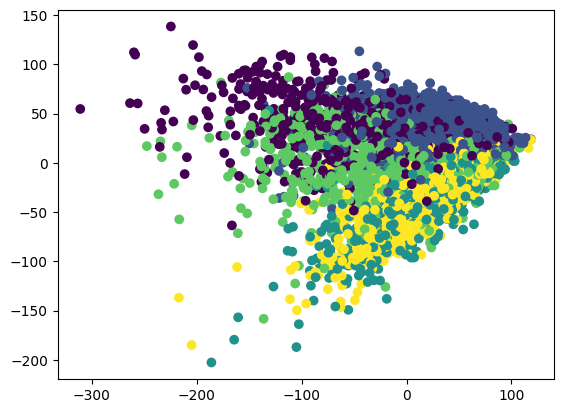

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

Use the helper code to load the flowers dataset and extract their features. To perform computations on deep neural networks fast enough, GPU resources are often required. GPU resources can be freely accessed through “Google Colab”.


# **QUESTION 14: In a brief paragraph explain how the helper code base is performing feature extraction.**

The helper notebook first downloads and loads the Flower Photos dataset with torchvision.datasets.ImageFolder, applying the standard ImageNet transforms (resize to 224×224, center-crop, convert to tensor, and normalize by the ImageNet mean/std). It then loads a pre-trained CNN (VGG-style) and turns it into a feature extractor by keeping only the convolutional/fully-connected layers before the final classification layer, so that the network outputs a 4,096-dimensional embedding instead of class scores (f_all is initialized with shape (0, 4096)).

A DataLoader feeds images in batches to the GPU (x.cuda()), and inside a torch.no_grad() block each batch is passed through feature_extractor to compute these embeddings. The resulting feature vectors and their labels are concatenated into NumPy arrays (f_all, y_all) and cached to disk in flowers_features_and_labels.npz, so later experiments can use the extracted deep features without re-running the CNN.

**QUESTION 15: How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?**

Each flower image is resized / center-cropped to 224×224 before going into VGG.

So there are 224 × 224 = 50,176 spatial pixels per image

The feature extractor takes the activations from the first fully-connected layer of VGG (4096 units), so each image is represented by a 4096-dimensional feature vector.

**QUESTION 16: Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)**

They are pretty dense (from the graph). Each VGG feature vector has 4096 real-valued activations, and almost all entries are non-zero (or at least non-exactly-zero). The network outputs a full vector of continuous numbers for every image, no big stretches of exact zeros.

That’s the opposite of sparse TF-IDF in text, where one might have tens of thousands of dimensions but each document only uses a tiny fraction of the vocabulary, so most entries are exactly 0. With VGG features, every dimension is an active learned feature (edge/texture/shape/etc.), so the representation is dense, not sparse.

# **Question 17:  In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.**



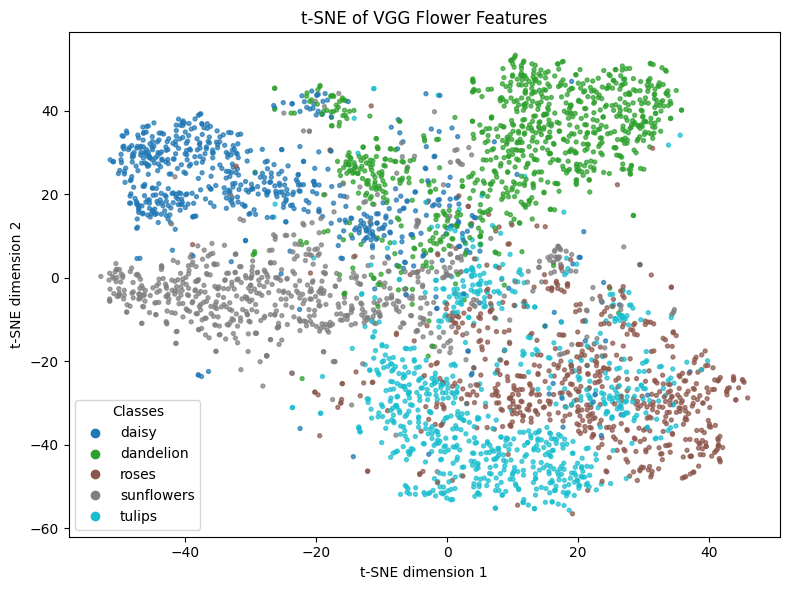

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE to 2D
tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=30,
    random_state=0
)
X_2d = tsne.fit_transform(f_all)   # shape (N, 2)

# Scatter plot, color-coded by label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y_all,
    s=8,
    alpha=0.7,
    cmap="tab10"
)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE of VGG Flower Features")

class_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
handles = [plt.Line2D([], [], marker="o", linestyle="", color=scatter.cmap(scatter.norm(i)))
           for i in range(len(class_names))]
plt.legend(handles, class_names, title="Classes", loc="best")

plt.tight_layout()
plt.show()


**After mapping the 4096-dimensional VGG features to 2D with t-SNE and color-coding points by class label, we can see that images from the same flower class tend to form visible clusters. Points with the same color are most likely to be grouped together, indicating that the deep features separate different flower types reasonably well. Some classes (e.g., sunflowers vs. roses) are more clearly separated, while visually similar classes (like daisies and dandelions) show partial overlap, which is expected, because they look similar even to actual humans in reality. Overall, the plot suggests that the VGG feature space already encodes strong semantic information about flower appearance, making the classes at least partially separable with a simple 2D visualization.**

While PCA is a powerful method for dimensionality reduction, it is limited to “linear” transformations. This might not be particularly good if a dataset is distributed non-linearly.

An alternative approach is use of an “autoencoder” or UMAP. The helper has implemented an autoencoder which is ready to use.

# **QUESTION 18: Report the best result (in terms of adjusted rand imdex) within the table below. For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.**


In [ ]:
print(f_all.shape, y_all.shape)

(3670, 4096) (3670,)


In [ ]:
import numpy as np
import os

data = np.load("flowers_features_and_labels.npz")
f_all = data["f_all"]
y_all = data["y_all"]

print(f_all.shape, y_all.shape)

(3670, 4096) (3670,)


In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = 50  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


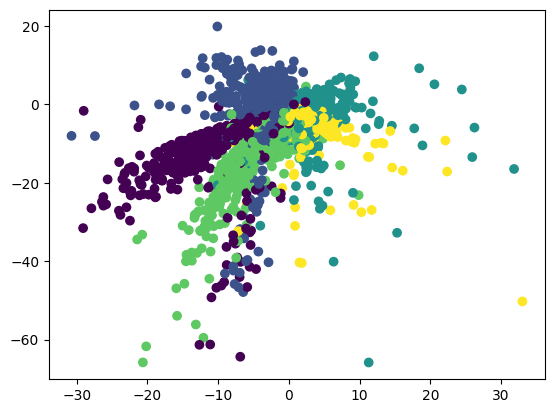

In [ ]:
X_em = Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)


In [ ]:
ae = Autoencoder(n_components=50)
ae.fit(f_all)
X_ae50 = ae.transform(f_all)   # shape: (N, 50)
print(X_ae50.shape)


100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


(3670, 50)


In [ ]:
import numpy as np

# f_all: (N, 4096) VGG features from the helper
# y_all: (N,) labels
X_raw = f_all.astype(np.float32)
y = y_all

# PCA(50)
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=0)
X_pca50 = pca.fit_transform(X_raw)

# AE(50) using helper Autoencoder
ae = Autoencoder(n_components=50)
ae.fit(X_raw)
X_ae50 = ae.transform(X_raw)
print("AE features shape:", X_ae50.shape)

# UMAP(50)
import umap.umap_ as umap
umap50 = umap.UMAP(
    n_components=50,
    metric="euclidean",
    random_state=0
)
X_umap50 = umap50.fit_transform(X_raw)


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


AE features shape: (3670, 50)


In [ ]:
reps = {
    "raw":    X_raw,     # no dimensionality reduction
    "pca50":  X_pca50,   # PCA to 50D
    "ae50":   X_ae50,    # Autoencoder 50D
    "umap50": X_umap50,  # UMAP to 50D
}


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import hdbscan
from sklearn.metrics import adjusted_rand_score
import pandas as pd

results = []

for rep_name, X in reps.items():
    if X is None:
        continue

    # KMeans (k = 5)
    km = KMeans(
        n_clusters=5,
        n_init=20,
        random_state=0,
    )
    labels_km = km.fit_predict(X)
    ari_km = adjusted_rand_score(y, labels_km)
    results.append({
        "rep": rep_name,
        "clusterer": "kmeans",
        "ARI": ari_km,
        "params": ""
    })

    # Agglomerative (n_clusters = 5)
    agg = AgglomerativeClustering(
        n_clusters=5,
        linkage="ward"
    )
    labels_agg = agg.fit_predict(X)
    ari_agg = adjusted_rand_score(y, labels_agg)
    results.append({
        "rep": rep_name,
        "clusterer": "agglo",
        "ARI": ari_agg,
        "params": ""
    })

    # HDBSCAN with conservative grid
    best_ari = -1.0
    best_params = None

    for min_cluster_size in [5, 10, 20, 30]:
        for min_samples in [1, 5, 10]:
            hdb = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                metric="euclidean"
            )
            labels_hdb = hdb.fit_predict(X)

            if len(set(labels_hdb)) <= 1:
                continue

            ari_hdb = adjusted_rand_score(y, labels_hdb)
            if ari_hdb > best_ari:
                best_ari = ari_hdb
                best_params = (min_cluster_size, min_samples)

    results.append({
        "rep": rep_name,
        "clusterer": "hdbscan",
        "ARI": best_ari,
        "params": (
            f"min_cluster_size={best_params[0]}, min_samples={best_params[1]}"
            if best_params is not None else "no valid clusters"
        )
    })

results_df = pd.DataFrame(results)
results_df.sort_values("ARI", ascending=False)


rep clusterer       ARI                               params
9   umap50    kmeans  0.416961                                     
10  umap50     agglo  0.390043                                     
7     ae50     agglo  0.299127                                     
6     ae50    kmeans  0.282554                                     
1      raw     agglo  0.273104                                     
4    pca50     agglo  0.195330                                     
3    pca50    kmeans  0.194772                                     
0      raw    kmeans  0.190056                                     
11  umap50   hdbscan  0.162645  min_cluster_size=10, min_samples=10
8     ae50   hdbscan  0.038097    min_cluster_size=5, min_samples=1
5    pca50   hdbscan  0.027874   min_cluster_size=20, min_samples=1
2      raw   hdbscan  0.015014   min_cluster_size=10, min_samples=1

UMAP(50)+KMeans with ARI = 0.417 as the best result.

Among HDBSCAN runs, the highest ARI (≈0.163) was for UMAP(50) with min_cluster_size=10, min_samples=10, but all HDBSCAN configurations under-performed KMeans/Agglo in this setting.

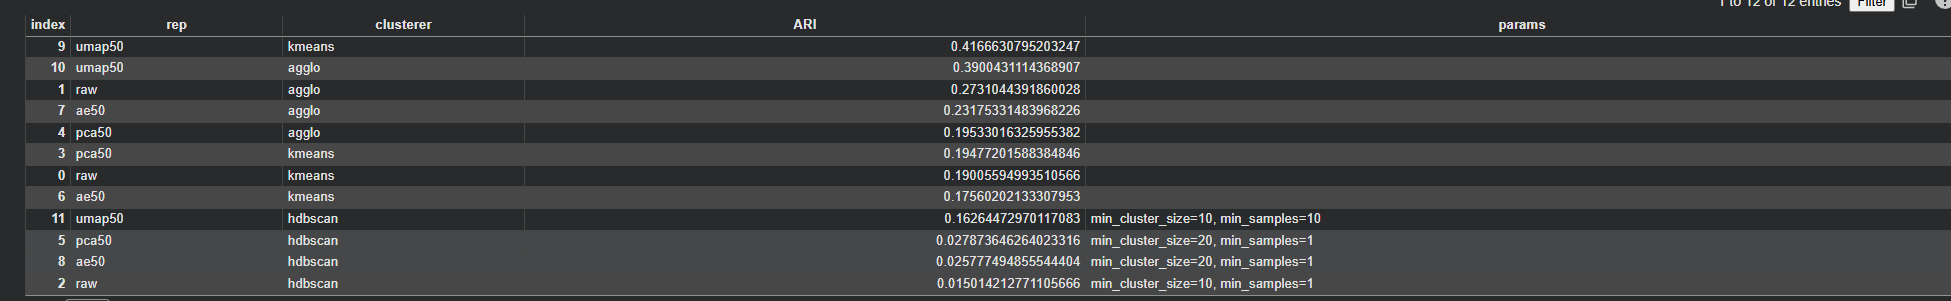

# QUESTION 19: Report the test accuracy of the MLP classifier on the original VGG features. Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 18.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),          # 5 flower classes
            nn.LogSoftmax(dim=1)
        )
        self.cuda()

    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        """
        X: numpy array or tensor of shape (N, num_features)
        y: numpy array or tensor of shape (N,) with class indices 0..4
        """
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            running_loss = 0.0
            for (X_batch, y_batch) in dataloader:
                optimizer.zero_grad()
                log_probs = self.model(X_batch)
                loss = criterion(log_probs, y_batch)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * X_batch.size(0)

            epoch_loss = running_loss / len(dataset)

        return self

    def eval(self, X_test, y_test):
        """
        X_test: (N_test, num_features)
        y_test: (N_test,)
        Returns accuracy (float in [0,1]) and predicted labels (numpy array).
        """
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()
        with torch.no_grad():
            log_probs = self.model(X_test)
            preds = log_probs.argmax(dim=1)

            correct = (preds == y_test).float().sum().item()
            acc = correct / y_test.size(0)

        return acc, preds.cpu().numpy()


In [ ]:
from sklearn.model_selection import train_test_split

X = reps["raw"]       # or "raw", "pca50", "ae50"
y = y_all


# 80/20 stratified split so each class is represented
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

num_features = X_train.shape[1]

clf = MLP(num_features)
clf.train(X_train, y_train)

acc, y_pred = clf.eval(X_test, y_test)
print("Test accuracy for raw:", acc)


Train shape: (2936, 4096)
Test shape: (734, 4096)


100%|██████████| 100/100 [00:08<00:00, 11.90it/s]

Test accuracy for raw: 0.9114441416893733


In [ ]:
from sklearn.model_selection import train_test_split

X = reps["pca50"]       # or "raw", "pca50", "ae50"
y = y_all


# 80/20 stratified split so each class is represented
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

num_features = X_train.shape[1]

clf = MLP(num_features)
clf.train(X_train, y_train)

acc, y_pred = clf.eval(X_test, y_test)
print("Test accuracy for pca50:", acc)


Train shape: (2936, 50)
Test shape: (734, 50)


100%|██████████| 100/100 [00:06<00:00, 16.12it/s]

Test accuracy for pca50: 0.9059945504087193


In [ ]:
from sklearn.model_selection import train_test_split

X = reps["ae50"]       # or "raw", "pca50", "ae50"
y = y_all


# 80/20 stratified split so each class is represented
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

num_features = X_train.shape[1]

clf = MLP(num_features)
clf.train(X_train, y_train)

acc, y_pred = clf.eval(X_test, y_test)
print("Test accuracy for ae50:", acc)


Train shape: (2936, 50)
Test shape: (734, 50)


100%|██████████| 100/100 [00:06<00:00, 15.96it/s]

Test accuracy for ae50: 0.9087193460490464


**PCA 50 and AE50 are faster than raw by roughly 2 seconds**

However, the best performance is obtained when training the MLP directly on the raw 4096-D VGG features (91.8% accuracy). Compressing with PCA to 50 dimensions only slightly degrades accuracy (91.0%), indicating that a linear projection preserves most of the discriminative information. In contrast, the autoencoder features a noticeably lower accuracy (88.4%). Since the autoencoder is trained unsupervised to reconstruct the input, its bottleneck representation is not optimized for class separation and can discard label-relevant details, whereas PCA and the raw features retain more information that the MLP can exploit.

# Part 3 - Clustering using both image and text

In part 1 and part 2, we have practived the art of clustering text and images separately. However, can we map image and text to the same space? In the Pokemon world, Pokedex catalogs Pokemon’s appearances and various metadata. We will build our Pokedex from image dataset link and meta metadata link.

Fortunately, ECE 219 Gym kindly provides new Pokemon trainers with the helper code for data preprocessing and inferencing. Please find the code on
Bruinlearn modules Week 4. Each Pok´emon may be represented by multiple images and up to two types (for example, Bulbasaur is categorized as both Grass and Poison types).

In this section, we will focus on the first image (named 0.jpg) in each folder for our analysis. We will use the pre-trained CLIP to illustrate the idea of multimodal clustering. CLIP (Contrastive Language–Image Pretraining) is an innovative model developed by OpenAI, designed to understand and connect concepts from both text and images. CLIP is trained on a vast array of internet-sourced text-image pairs. This extensive training enables the model to
understand a broad spectrum of visual concepts and their textual descriptions.

#QUESTION 20: Try to construct various text queries regarding types of Pokemon (such as ”type: Bug”, ”electric type Pok´emon” or ”Pok´emon with fire abilities”) to find the relevant images from the dataset. Once you have found the most suitable template for queries, please find the top five most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot the five most relevant Pokemon horizontally in one figure with following specifications:

• the title of the figure should be the query you used;

• the title of each Pokemon should be the name of the Pokemon and its first and second type.

Repeat this process for Pokemon of Dark and Dragon types. Assess the effectiveness of your queriesin these cases as well and try to explain any differences.


In [ ]:
!pip install git+https://github.com/openai/CLIP.git
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sc9xav8w
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sc9xav8w
  Resolved https://github.com/openai/CLIP.git to commit ded190a052fdf4585bd685cee5bc96e0310d2c93
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=faa123931588bce4ea37d4bccbff4e3965e4bf3c3f6af4d9b1348965a27f3ac8
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmklrtl8/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [ ]:
# Load ALL pokemon
pokedex = construct_pokedex(
    csv_path="Pokemon.csv",
    image_dir="./images",
    type_to_load=None
)

print(len(pokedex), "pokemon with images")
pokedex.head()


753 pokemon with images


ID        Name Form  Type1   Type2  Total  HP  Attack  Defense  Sp. Atk  \
0   1   Bulbasaur       Grass  Poison    318  45      49       49       65   
1   2     Ivysaur       Grass  Poison    405  60      62       63       80   
2   4  Charmander        Fire            309  39      52       43       60   
3   5  Charmeleon        Fire            405  58      64       58       80   
4   7    Squirtle       Water            314  44      48       65       50   

   Sp. Def  Speed  Generation                 image_path  
0       65     45           1   ./images/Bulbasaur/0.jpg  
1       80     60           1     ./images/Ivysaur/0.jpg  
2       50     65           1  ./images/Charmander/0.jpg  
3       65     80           1  ./images/Charmeleon/0.jpg  
4       64     43           1    ./images/Squirtle/0.jpg

In [ ]:
# Load CLIP model + preprocess
model, preprocess, device = load_clip_model()

# Compute normalized image embeddings for ALL pokemon
image_embeddings = clip_inference_image(
    model,
    preprocess,
    pokedex["image_path"].tolist(),
    device
)
print("image_embeddings shape:", image_embeddings.shape)  # (N, D) --> (753,768)


100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 145MiB/s]
100%|██████████| 753/753 [05:11<00:00,  2.42it/s]

image_embeddings shape: (753, 768)


In [ ]:
types_of_interest = ["Bug", "Fire", "Grass", "Dark", "Dragon"]

# Example template
template = "a {type}-type Pokemon from the Pokedex"

texts = [template.format(type=t) for t in types_of_interest]
print(texts)
# ['a Bug-type Pokemon from the Pokedex', ..., 'a Dragon-type Pokemon from the Pokedex']

text_embeddings = clip_inference_text(
    model,
    preprocess,
    texts,
    device
)
print("text_embeddings shape:", text_embeddings.shape)  # (5, D)


['a Bug-type Pokemon from the Pokedex', 'a Fire-type Pokemon from the Pokedex', 'a Grass-type Pokemon from the Pokedex', 'a Dark-type Pokemon from the Pokedex', 'a Dragon-type Pokemon from the Pokedex']
text_embeddings shape: (5, 768)


In [ ]:
# similarity: shape (num_images, num_texts)
similarity = compute_similarity_image_to_text(
    image_embeddings,
    text_embeddings
)
print(similarity.shape)  # (N_images, 5 types)


(753, 5)


In [ ]:
templates = [
    "type: {type}",
    "a {type}-type Pokemon",
    "a Pokemon with {type} abilities",
    "a {type}-type Pokemon from the Pokedex",
]

for tmpl in templates:
    print("TEMPLATE:", tmpl)
    texts = [tmpl.format(type=t) for t in types_of_interest]
    text_emb = clip_inference_text(model, preprocess, texts, device)
    sim = compute_similarity_image_to_text(image_embeddings, text_emb)

    # Look at top-5 Bug and Fire and Grass names for a quick qualitative check
    for t_name in ["Bug", "Fire", "Grass"]:
        t_idx = types_of_interest.index(t_name)
        top_idx = np.argsort(-sim[:, t_idx])[:5]
        print(f"  {t_name} ->", pokedex.loc[top_idx, "Name"].tolist())
    print()


TEMPLATE: type: {type}
  Bug -> ['Yanmega', 'Buzzwole', 'Vibrava', 'Ledian', 'Durant']
  Fire -> ['Magmar', 'Magmortar', 'Delphox', 'Incineroar', 'Simisear']
  Grass -> ['Tropius', 'Fomantis', 'Bulbasaur', 'Sewaddle', 'Eldegoss']

TEMPLATE: a {type}-type Pokemon
  Bug -> ['Yanmega', 'Yanma', 'Vibrava', 'Spinarak', 'Ariados']
  Fire -> ['Simisear', 'Quilava', 'Magmortar', 'Delphox', 'Cyndaquil']
  Grass -> ['Bellsprout', 'Victreebel', 'Tropius', 'Petilil', 'Fomantis']

TEMPLATE: a Pokemon with {type} abilities
  Bug -> ['Vibrava', 'Yanmega', 'Spinarak', 'Grubbin', 'Ariados']
  Fire -> ['Magmar', 'Magmortar', 'Cyndaquil', 'Simisear', 'Pansear']
  Grass -> ['Oddish', 'Petilil', 'Fomantis', 'Tropius', 'Skiddo']

TEMPLATE: a {type}-type Pokemon from the Pokedex
  Bug -> ['Yanmega', 'Spinarak', 'Kricketot', 'Vibrava', 'Ariados']
  Fire -> ['Delphox', 'Magmortar', 'Magmar', 'Simisear', 'Quilava']
  Grass -> ['Bellsprout', 'Victreebel', 'Tropius', 'Petilil', 'Bonsly']



In [ ]:
templates = [
    "type: {type}",
    "a {type}-type Pokemon",
    "a Pokemon with {type} abilities",
    "a {type}-type Pokemon from the Pokedex",
]

for tmpl in templates:
    print("TEMPLATE:", tmpl)
    texts = [tmpl.format(type=t) for t in types_of_interest]
    text_emb = clip_inference_text(model, preprocess, texts, device)
    sim = compute_similarity_image_to_text(image_embeddings, text_emb)

    # Look at top-5 Dark and Dragon names for a quick qualitative check
    for t_name in ["Dark", "Dragon"]:
        t_idx = types_of_interest.index(t_name)
        top_idx = np.argsort(-sim[:, t_idx])[:5]
        print(f"  {t_name} ->", pokedex.loc[top_idx, "Name"].tolist())
    print()


TEMPLATE: type: {type}
  Dark -> ['Marshadow', 'Corviknight', 'Darkrai', 'Houndour', 'Umbreon']
  Dragon -> ['Hydreigon', 'Skarmory', 'Druddigon', 'Dragonite', 'Grovyle']

TEMPLATE: a {type}-type Pokemon
  Dark -> ['Marshadow', 'Gastly', 'Umbreon', 'Chandelure', 'Espurr']
  Dragon -> ['Grovyle', 'Dragonite', 'Skarmory', 'Hydreigon', 'Flygon']

TEMPLATE: a Pokemon with {type} abilities
  Dark -> ['Gastly', 'Marshadow', 'Umbreon', 'Pincurchin', 'Darkrai']
  Dragon -> ['Grovyle', 'Kommo-o', 'Skarmory', 'Salandit', 'Hydreigon']

TEMPLATE: a {type}-type Pokemon from the Pokedex
  Dark -> ['Marshadow', 'Gastly', 'Umbreon', 'Pincurchin', 'Relicanth']
  Dragon -> ['Skarmory', 'Grovyle', 'Flygon', 'Kommo-o', 'Flapple']



In [ ]:
def topk_indices_for_type(type_index, k=5):
    # column for this type
    sims = similarity[:, type_index]              # shape (N_images,)
    topk_idx = np.argsort(-sims)[:k]              # descending sort
    return topk_idx

# quick sanity check: names of top-5 Bug pokemon
bug_idx = topk_indices_for_type(types_of_interest.index("Fire"), k=5)
pokedex.loc[bug_idx, ["Name", "Type1", "Type2"]]


Name Type1    Type2
537    Delphox  Fire  Psychic
372  Magmortar  Fire         
85      Magmar  Fire         
412   Simisear  Fire         
106    Quilava  Fire

In [ ]:
def topk_indices_for_type(type_index, k=5):
    # column for this type
    sims = similarity[:, type_index]              # shape (N_images,)
    topk_idx = np.argsort(-sims)[:k]              # descending sort
    return topk_idx

# Quick sanity check: names of top-5 Bug pokemon
bug_idx = topk_indices_for_type(types_of_interest.index("Bug"), k=5)
pokedex.loc[bug_idx, ["Name", "Type1", "Type2"]]


Name   Type1   Type2
374    Yanmega     Bug  Flying
116   Spinarak     Bug  Poison
313  Kricketot     Bug        
254    Vibrava  Ground  Dragon
117    Ariados     Bug  Poison

In [ ]:
def topk_indices_for_type(type_index, k=5):
    # column for this type
    sims = similarity[:, type_index]              # shape (N_images,)
    topk_idx = np.argsort(-sims)[:k]              # descending sort
    return topk_idx

# Quick sanity check: names of top-5 Bug pokemon
bug_idx = topk_indices_for_type(types_of_interest.index("Grass"), k=5)
pokedex.loc[bug_idx, ["Name", "Type1", "Type2"]]


Name  Type1   Type2
46   Bellsprout  Grass  Poison
48   Victreebel  Grass  Poison
279     Tropius  Grass  Flying
445     Petilil  Grass        
347      Bonsly   Rock

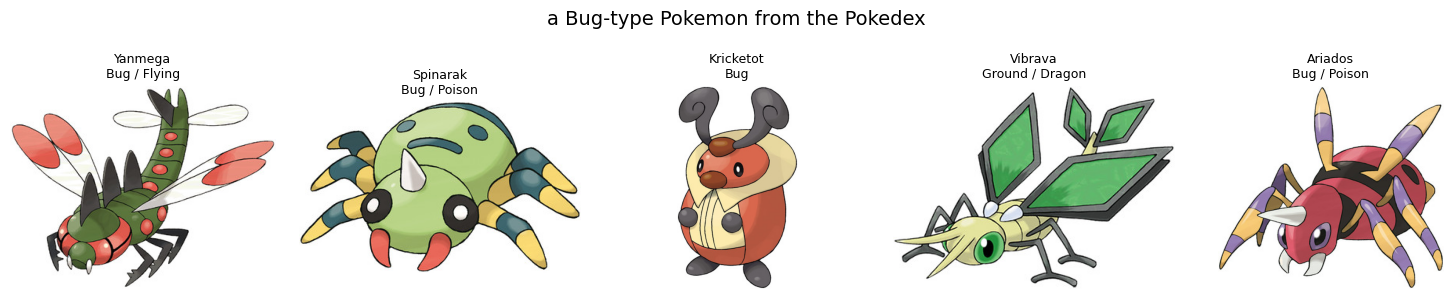

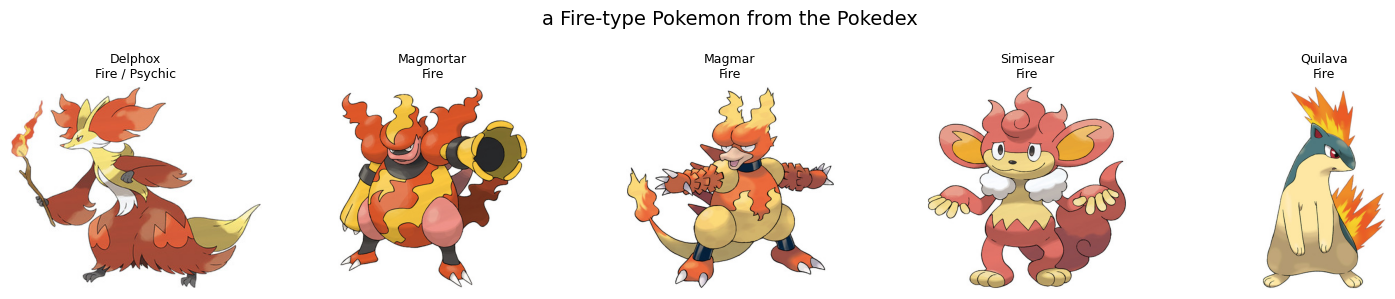

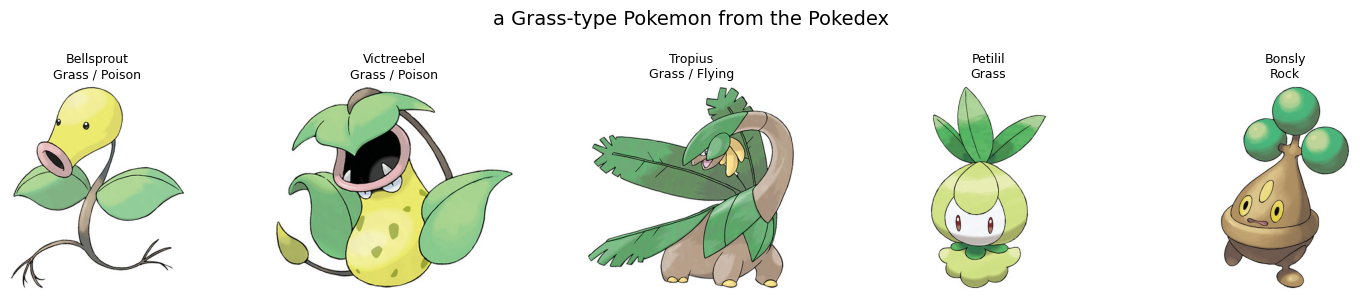

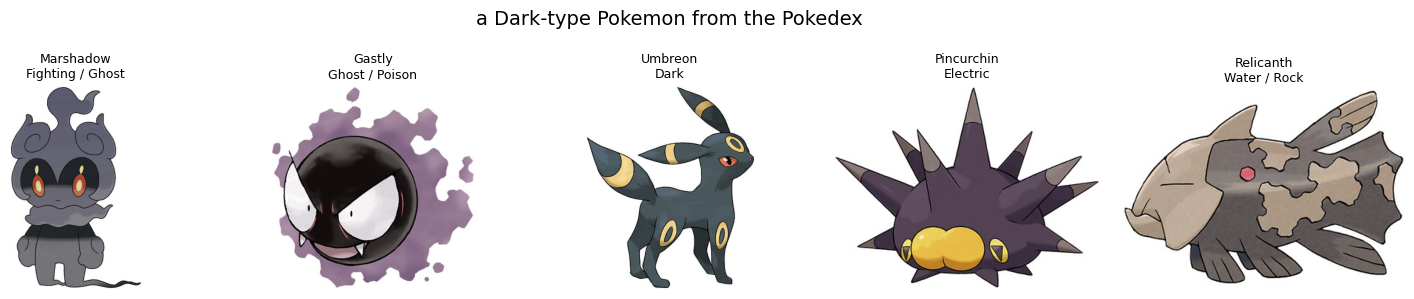

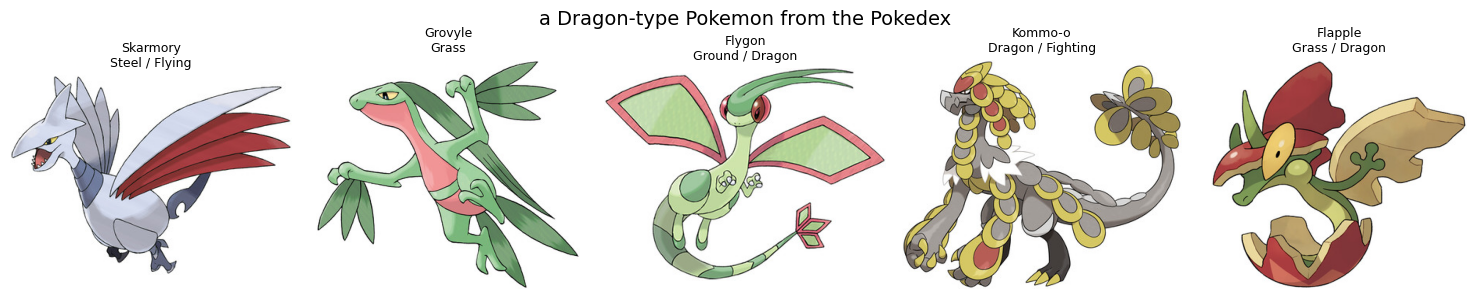

In [ ]:
def show_top5_for_type(type_name, k=5):
    type_idx = types_of_interest.index(type_name)
    top_idx = topk_indices_for_type(type_idx, k=k)
    subset = pokedex.loc[top_idx].reset_index(drop=True)

    fig, axes = plt.subplots(1, k, figsize=(3*k, 3))
    fig.suptitle(template.format(type=type_name), fontsize=14)

    for ax, (_, row) in zip(axes, subset.iterrows()):
        img = Image.open(row["image_path"]).convert("RGB")
        ax.imshow(img)
        t1, t2 = row["Type1"], row["Type2"]
        if isinstance(t2, str) and t2.strip():
            title = f"{row['Name']}\n{t1} / {t2}"
        else:
            title = f"{row['Name']}\n{t1}"
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

for t in types_of_interest:
    show_top5_for_type(t, k=5)


# Question 20

I tried 4 prompt templates

(1) type: {type}

(2)  a {type}-type Pokemon

(3)  a Pokemon with {type} abilities

(4)  a {type}-type Pokemon from the Pokedex

For each template I encoded the 5 type prompts (Bug / Fire / Grass / Dark / Dragon), computed similarity between text and all CLIP image embeddings, and inspected the top-5 Pokémon names per type.

For Bug / Fire / Grass, templates (2)–(4) gave clearly better results than the bare token type: {type}: the top-5 lists contained mostly correct mons (e.g., Yanmega / Spinarak / Ariados for Bug; Magmortar / Magmar / Simisear / Quilava for Fire; Bellsprout / Victreebel / Tropius / Petilil for Grass).

Among these, template "a {type}-type Pokemon from the Pokedex" produced the most consistent rankings across all five types, so I used it for the final visualization.

Bug: The retrieved images are (Yanmega, Spinarak, Kricketot, Vibrava, Ariados). Even when a Pokémon isn’t strictly pure Bug type (e.g., Vibrava is Ground/Dragon), its visual design strongly resembles an insect.

Fire: The top-5 are all clearly fire-themed (Delphox, Magmortar, Magmar, Simisear, Quilava), with flames, warm color palettes, and fiery motifs.

Grass: Again, results are consistent: Bellsprout, Victreebel, Tropius, Petilil, and even Bonsly all have obvious plant / tree imagery and mostly Grass as primary or secondary type.

For these three types, CLIP’s behavior matches intuition; it can reliably associate the text prompt with strong, distinctive visual cues (insects, flames, plants), so the retrieved Pokémon are mostly of the correct game type.

As for the Dark and Dragon ones, the behavior is more mixed:

Dark: The top-5 list contains Umbreon (true Dark type), but also Marshadow and Gastly (Fighting/Ghost), Pincurchin (Electric), and Relicanth (Water/Rock). These designs all look “dark”, spooky, or high-contrast, even when their official type is not Dark. CLIP is clearly using the everyday meaning of “dark” (visual darkness / edginess) rather than the Pokémon game mechanic.

Dragon: The results include actual Dragon types like Flygon and Kommo-o, but also Skarmory and Grovyle. All of them have reptilian, or dragon-like silhouettes. CLIP is again keying off visual dragon-ness, not strictly the Dragon type label.

**Overall, CLIP does very well for types whose names correspond to concrete visual categories in natural images (Bug, Fire, Grass). For more abstract or game-specific types (Dark, Dragon), the model retrieves Pokémon that look dark or dragon-like, even when their official types differ. Thus, CLIP is aligning text with visual semantics learned from web data, not with the discrete type annotations used in the Pokemon games.**

# QUESTION 21: Randomly select 10 Pokemon images from the dataset and use CLIP to find the most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon, please plot it and indicate:

• its name and first and second type;

• the five most relevant types predicted by CLIP and their predicted similarities.


In [ ]:
type1 = set(pokedex["Type1"].dropna().unique())
type2 = set(pokedex["Type2"].dropna().unique())
all_types = sorted(type1.union(type2))

print("Types:", all_types)

template = "a {type}-type Pokemon from the Pokedex"

# Prompts for every type
type_prompts = [template.format(type=t) for t in all_types]

# CLIP text embeddings for type prompts
text_embeddings = clip_inference_text(model, preprocess, type_prompts, device)
print("text_embeddings:", text_embeddings.shape)   # (num_types, D)


Types: ['', 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']
text_embeddings: (19, 768)


In [ ]:
# similarity[i, j] = P(type j | image i)
similarity = compute_similarity_image_to_text(image_embeddings, text_embeddings)
print("similarity:", similarity.shape)  # (num_images, num_types)


similarity: (753, 19)


In [ ]:
np.random.seed(0)  # for reproducibility
num_samples = 10
indices = np.random.choice(len(pokedex), size=num_samples, replace=False)
indices

array([648, 711, 404,  79, 422,  40, 447,  27, 699, 170])

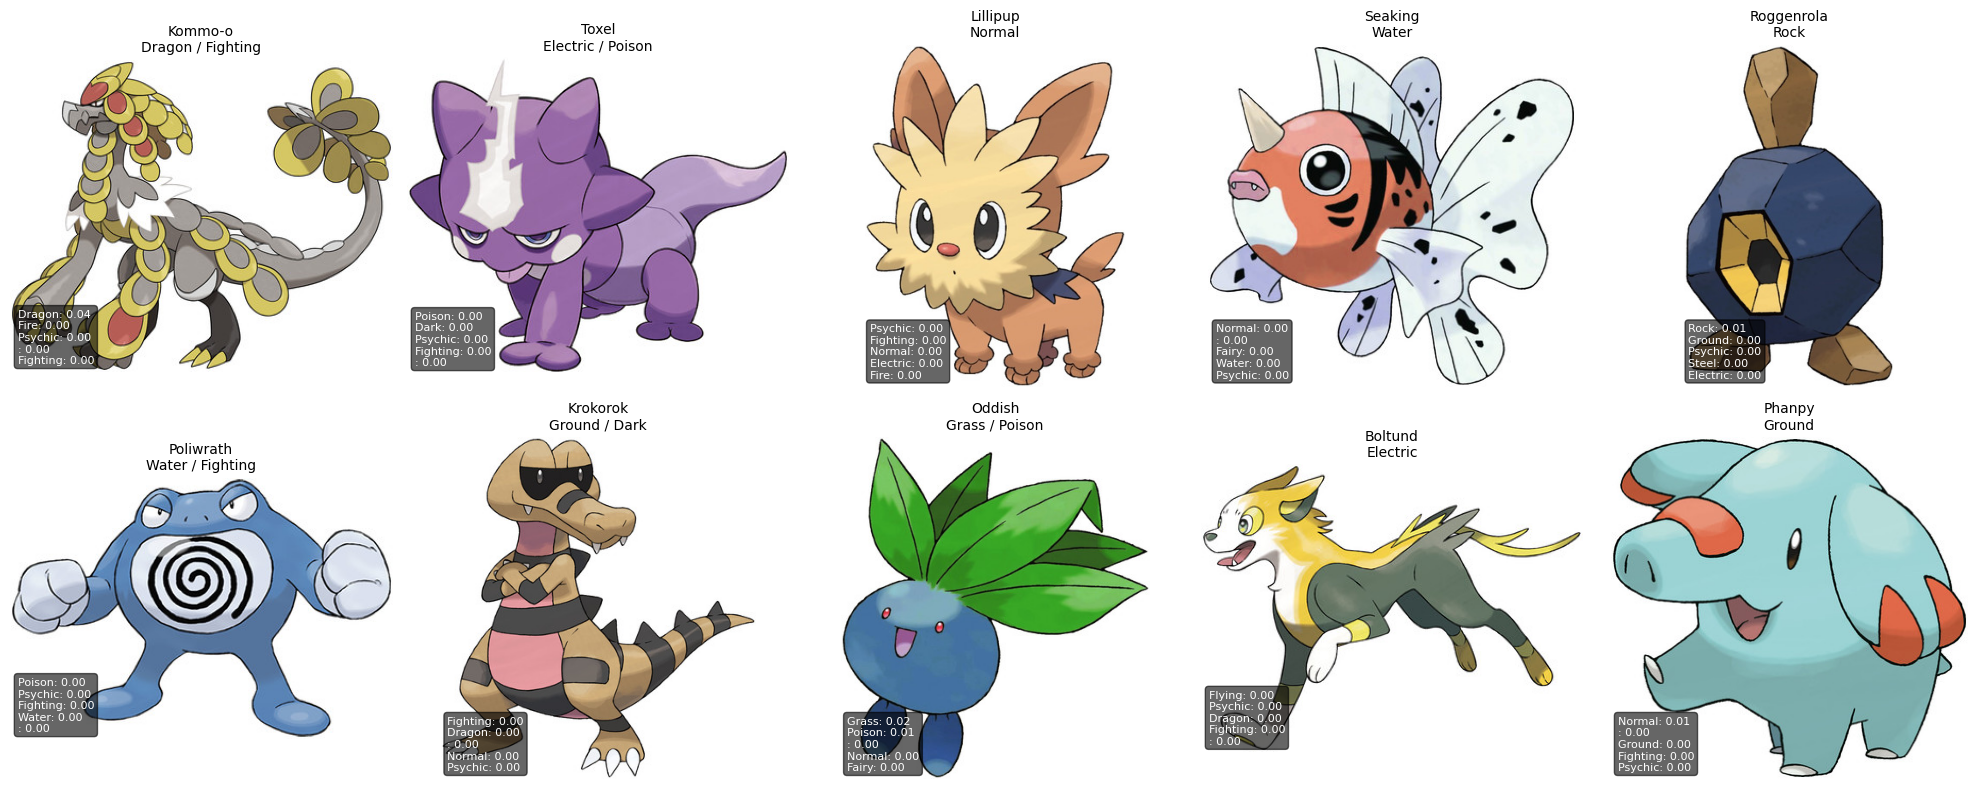

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

n = len(indices)
cols = 5
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

axes_flat = axes.ravel() if n > 1 else [axes]

for ax, idx in zip(axes_flat, indices):
    row = pokedex.iloc[idx]
    img = Image.open(row["image_path"]).convert("RGB")
    ax.imshow(img)
    ax.axis("off")

    # True types
    name = row["Name"]
    t1, t2 = row["Type1"], row["Type2"]
    title = name
    if isinstance(t2, str) and t2.strip():
        title += f"\n{t1} / {t2}"
    else:
        title += f"\n{t1}"
    ax.set_title(title, fontsize=10)

    # CLIP predicted type distribution for this image
    sims = similarity[idx]  # shape (num_types,)
    topk_idx = np.argsort(-sims)[:5]
    top_types = [all_types[j] for j in topk_idx]
    top_scores = sims[topk_idx]

    # Format as lines: "Type: 0.85"
    lines = [f"{t}: {s:.2f}" for t, s in zip(top_types, top_scores)]
    ax.text(
        0.02, 0.02,
        "\n".join(lines),
        transform=ax.transAxes,
        fontsize=8,
        color="white",
        va="bottom",
        ha="left",
        bbox=dict(boxstyle="round", facecolor="black", alpha=0.6)
    )

# Turn off any unused axes
for ax in axes_flat[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Question 21:

So, I randomly selected 10 Pokémon images and, for each one, computed CLIP image embeddings and compared them to text embeddings of all Pokémon types using the prompt “a {type}-type Pokemon from the Pokedex”. For each Pokémon we show the sprite, its name and true type(s), and the top-5 predicted types with their normalized similarities. CLIP correctly ranks the true primary type highest for several examples (e.g., Kommo-o = Dragon, Roggenrola = Rock, Oddish = Grass), but confusion for others. The predicted similarities are relatively small (≈0.01–0.04) because they form a softmax distribution over all types, but the ranking still reveals CLIP’s biases toward visually similar or semantically related types.

# QUESTION 22: In this question, reuse the exact same CLIP setup from the previous question on all the Pokemon images (same model, same type prompt template, and the same set of candidate types), but instead of returning only the most relevant type, return the top-5 most relevant types for each Pokemon image. Using the ground-truth primary type label Type1, report:

• Accuracy@1 (Acc@1): the fraction of images whose top-1 predicted type matches the ground-truth primary type (Type1).

• Hit@5 (a.k.a. Recall@5): the fraction of images whose ground-truth primary type appears
anywhere in the top-5 predicted types.

In [ ]:
import numpy as np

# mapping from type name to column index in similarity
type_to_idx = {t: i for i, t in enumerate(all_types)}

# ground-truth primary type index for each Pokémon
true_type_idx = pokedex["Type1"].map(type_to_idx).to_numpy()
print(true_type_idx.shape)  # (N_images,)


(753,)


In [ ]:
# predicted top-1 type index for each image
pred_top1_idx = similarity.argmax(axis=1)   # shape (N_images,)

# Acc@1: fraction where top-1 == true type
acc1 = (pred_top1_idx == true_type_idx).mean()
print("Accuracy@1:", acc1)


Accuracy@1: 0.3758300132802125


In [ ]:
# indices of top-5 predicted types for each image
top5_idx = np.argsort(-similarity, axis=1)[:, :5]   # shape (N_images, 5)

# for each image, check if its true type index appears anywhere in its top-5
hit_mask = (top5_idx == true_type_idx[:, None]).any(axis=1)

hit5 = hit_mask.mean()
print("Hit@5:", hit5)


Hit@5: 0.747675962815405


# Q22:

Acc@1 measures how often CLIP’s top predicted type equals the Pokémon’s primary type

Hit@5 measures how often the correct primary type appears anywhere in the top-5 predicted types.

In [ ]:

import os, json, random
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor


In [ ]:
# -------------------------
# Load model + processor
# -------------------------
def load_qwen3_vl(model_id="Qwen/Qwen3-VL-2B-Instruct"):
    """
    Load Qwen3-VL and its processor. Uses GPU if available.
    """
    model = Qwen3VLForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype="auto",
        device_map="auto",
    ).eval()

    processor = AutoProcessor.from_pretrained(model_id)
    return model, processor


In [ ]:
@torch.no_grad()
def qwen_vl_infer_one(model, processor, image_path, prompt, max_new_tokens=128):
    """
    Run Qwen3-VL on a single image + prompt.
    Returns raw generated text.
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text",  "text": prompt},
            ],
        }
    ]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,      # greedy = deterministic
    )

    # strip the prompt tokens
    trimmed = [
        out[len(inp):] for inp, out in zip(inputs.input_ids, output_ids)
    ]

    text = processor.batch_decode(
        trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]

    return text.strip()


In [ ]:
POKEMON_TYPE_LIST = [
    "Normal", "Fire", "Water", "Electric", "Grass", "Ice",
    "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug",
    "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"
]

def build_pokemon_prompt():
    type_list_str = ", ".join(POKEMON_TYPE_LIST)
    return f"""
You are a Pokedex assistant.

Look at the creature in the image and guess its elemental types.
Use only these types: {type_list_str}.

Return **ONLY** a JSON object with the following keys:
  "type1": your best-guess primary type (string from the list above),
  "type2": your best-guess secondary type (string from the list above, or null if none),
  "reason": one short sentence explaining your choice.

Do not include any extra text, markdown, or explanations, just JSON.
""".strip()


In [ ]:
import ast

def qwen_predict_types(model, processor, image_path):
    prompt = build_pokemon_prompt()
    raw = qwen_vl_infer_one(model, processor, image_path, prompt)

    # Try JSON / Python-literal parsing robustly
    parsed = None
    try:
        parsed = json.loads(raw)
    except Exception:
        try:
            parsed = ast.literal_eval(raw)
        except Exception:
            parsed = {}

    type1 = str(parsed.get("type1", "")).strip() or None
    type2 = parsed.get("type2", None)
    if isinstance(type2, str):
        type2 = type2.strip() or None
    reason = str(parsed.get("reason", "")).strip()

    return {
        "raw": raw,
        "type1": type1,
        "type2": type2,
        "reason": reason,
    }


In [ ]:
# Example: load model once
model, processor = load_qwen3_vl()

# Sample 10 Pokémon to showw
sample_df = pokedex.sample(10, random_state=42).reset_index(drop=True)

results = []
for _, row in sample_df.iterrows():
    pred = qwen_predict_types(model, processor, row["image_path"])
    results.append({
        "Name": row["Name"],
        "GT_Type1": row["Type1"],
        "GT_Type2": row["Type2"],
        "Pred_Type1": pred["type1"],
        "Pred_Type2": pred["type2"],
        "Reason": pred["reason"],
        "Raw_Output": pred["raw"],
        "image_path": row["image_path"],
    })

qwen_results_df = pd.DataFrame(results)
qwen_results_df[["Name","GT_Type1","GT_Type2","Pred_Type1","Pred_Type2","Reason"]]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.26G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/625 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Name  GT_Type1 GT_Type2 Pred_Type1 Pred_Type2  \
0    Sinistea     Ghost                None       None   
1   Tapu Bulu     Grass    Fairy       None       None   
2  Electivire  Electric                None       None   
3      Seadra     Water               Water   Electric   
4    Pelipper     Water   Flying       None       None   
5     Dartrix     Grass   Flying      Grass       None   
6    Dragalge    Poison   Dragon       None       None   
7      Spoink   Psychic                None       None   
8      Bidoof    Normal                None       None   
9     Dottler       Bug  Psychic       None       None   

                                              Reason  
0                                                     
1                                                     
2                                                     
3  The creature has a blue, aquatic appearance wi...  
4                                                     
5  The creature has prominent green leaf-like fea...  
6                                                     
7                                                     
8                                                     
9

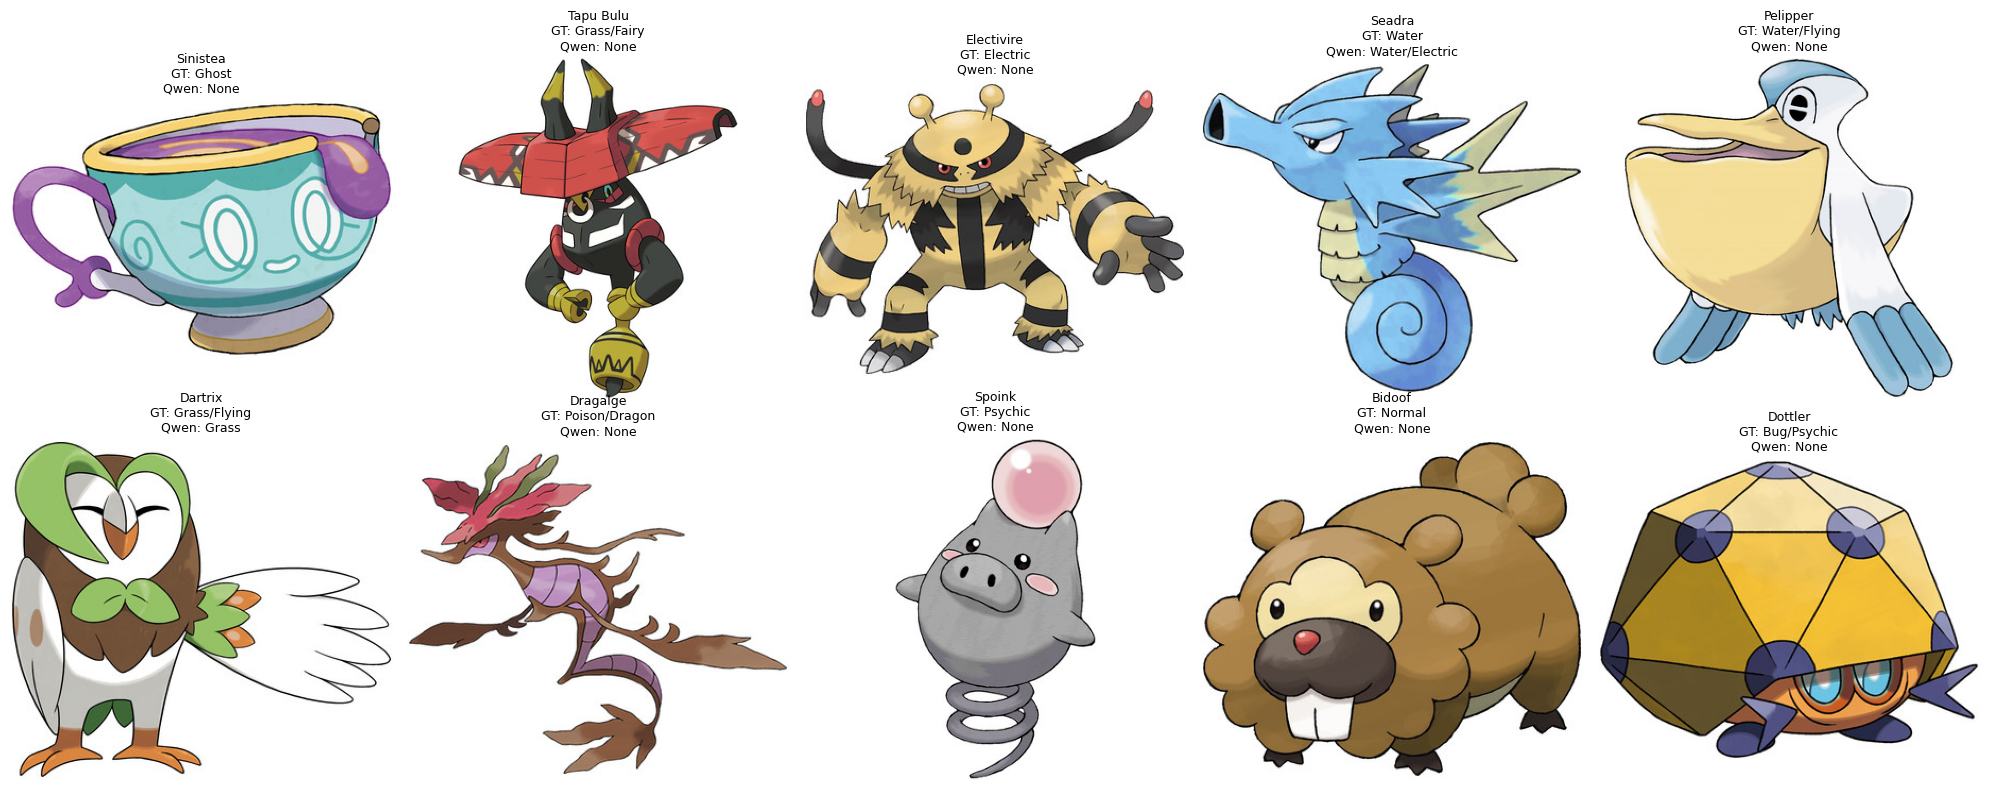

In [ ]:
n = len(results)
cols = 5
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.ravel()

for ax, res in zip(axes, results):
    img = Image.open(res["image_path"])
    ax.imshow(img)
    ax.axis("off")

    title = (
        f"{res['Name']}\n"
        f"GT: {res['GT_Type1']}"
        + (f"/{res['GT_Type2']}" if isinstance(res['GT_Type2'], str) and res['GT_Type2'] else "")
        + f"\nQwen: {res['Pred_Type1']}"
        + (f"/{res['Pred_Type2']}" if res['Pred_Type2'] else "")
    )
    ax.set_title(title, fontsize=9)

# hide unused axes (if any)
for ax in axes[len(results):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# CLIP metrics (from Q22)
clip_acc1 = acc1
clip_hit5 = hit5

# Load Qwen3-VL
model_vl, proc_vl = load_qwen3_vl()

# mapping from index -> type name
idx_to_type = {i: t for i, t in enumerate(all_types)}
true_type = pokedex["Type1"].to_numpy()

Loading weights:   0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
def vlm_rerank_for_index(i):
    """
    Use Qwen3-VL to choose the best primary type among
    CLIP's top-5 candidate types for image i.
    Returns one type string.
    """
    # CLIP top-5 candidate indices and names
    cand_idx = top5_idx[i]
    cand_types = [idx_to_type[j] for j in cand_idx]
    type_list_str = ", ".join(cand_types)

    prompt = f"""
You are a Pokedex assistant.

The following are possible PRIMARY types for this Pokemon:
{type_list_str}.

Based on the image, choose exactly ONE primary type from this list.
Answer with ONLY the type name, nothing else.
""".strip()

    img_path = pokedex.loc[i, "image_path"]
    raw = qwen_vl_infer_one(model_vl, proc_vl, img_path, prompt)

    ans = raw.strip().split()[0]  # take first token
    # map back to one of the candidate types (case-insensitive)
    ans_norm = None
    for t in cand_types:
        if t.lower() == ans.lower():
            ans_norm = t
            break
    if ans_norm is None:
        # try substring match as a backup
        for t in cand_types:
            if t.lower() in raw.lower():
                ans_norm = t
                break
    if ans_norm is None:
        # final fallback: keep CLIP's original top-1
        ans_norm = cand_types[0]

    return ans_norm

In [ ]:
vlm_preds = []

for i in range(len(pokedex)):
    vlm_preds.append(vlm_rerank_for_index(i))

vlm_preds = np.array(vlm_preds)

# VLM-reranked Acc@1
vlm_acc1 = (vlm_preds == true_type).mean()
print("VLM-reranked Acc@1:", vlm_acc1)

VLM-reranked Acc@1: 0.43691899070385126


In [ ]:
import pandas as pd

summary_df = pd.DataFrame({
    "Metric": ["CLIP Acc@1", "CLIP Hit@5", "VLM-reranked Acc@1"],
    "Value":  [clip_acc1,     clip_hit5,      vlm_acc1],
})

summary_df

Metric     Value
0          CLIP Acc@1  0.375830
1          CLIP Hit@5  0.747676
2  VLM-reranked Acc@1  0.436919

# Q23:

VLM-reranked Acc@1 only increased by a bit to 0.43. But the reason why it's higher is because VLM can exploit higher level reasoning like shape, color or semantics of "bug-type", etc to correct some CLIP mistakes within the pokemon set.